#### This notebook is used as an example for analyze the gene expression profile using the the FM-states framework. 
Citation of the input data: Tyner, J.W., Tognon, C.E., Bottomly, D. et al. Functional genomic landscape of acute myeloid leukaemia. Nature 562, 526–531 (2018). https://doi.org/10.1038/s41586-018-0623-z.

Major processes:<br /> 
1. Data processing
2. FM-factors generation
3. Clustering
4. Enrichment analysis using gene mutations
5. Comparing the blast percentage across different states
6. Predict drug sensitivity using FM-factors

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import Query
base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')
ROOT_DIR = os.path.abspath("../")

In [2]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example_beatAML/",
    'input_dir': ROOT_DIR+"/Sample_input/Example_beatAML/",
    'output_fmf_file':ROOT_DIR+"/Sample_output/Example_beatAML/" +"matrix_factor_beatAML.csv",
    'sele_modules': ['Translation',
        'Nucleotide metabolism',
        'Signal transduction',
        'Amino acid metabolism',
        'Folding sorting and degradation',
         'Replication and repair',
         'Carbohydrate metabolism',
         'Membrane transport',
         'Cellular community - eukaryotes',
         'Lipid metabolism',
         'Metabolism of other amino acids',
         'Transcription',
         'Xenobiotics biodegradation and metabolism',
         'Signaling molecules and interaction',
         'Energy metabolism',
         'Transport and catabolism',
         'Glycan biosynthesis and metabolism',
         'Metabolism of cofactors and vitamins',
         'Cell motility',
         'Cell cycle', 
         'Apoptosis', 
         'Cellular senescence', 
         'p53 signaling pathway']
}

#### 1. Data processing: formating beatAML gene expression input matrix

In [3]:
expr_m = pd.read_csv(para['input_dir'] +"RPKM_t.csv", index_col = "Unnamed: 0")
anno = pd.read_csv(para['input_dir'] + "Ensemble_symbol_annotation.csv", index_col = "Unnamed: 0")

In [4]:
dic_anno = {}

In [5]:
for i in range(0, anno.shape[0]):
    ens = anno.iloc[i,0]
    symbol = anno.iloc[i,1]
    dic_anno[ens] = symbol

In [6]:
symbol_list = []
ens_list = list(expr_m.columns)
for ens in ens_list:
    symbol_list.append(dic_anno[ens])
expr_m.columns = symbol_list

#### 2. Generate functional module factors for each AML patient sample.

In [ ]:
File_FM = os.path.join(ROOT_DIR,"Dataset/Sample_FM.csv")
dic_module,  KEGG_modules = FM_States.load_function_modules(File_FM)

module_selected_gmt = KEGG_modules.loc[KEGG_modules['name'].isin(para['sele_modules']) ]

TF_pairs = TF.get_tfpairs_for_select_pathways(expr_m,list(set(KEGG_modules['name']).intersection(para['sele_modules'])),dic_module)


TF_pairs.to_csv(para['output_dir'] +"/TF_pairs.csv")

matrix_factor = FM_States.generate_factor(expr_m, list(set(KEGG_modules['name']).intersection(para['sele_modules'])), module_selected_gmt, TF_pairs, UP = True, DOWN = True, ssGSEA = True, TF = True, absolute = True)
matrix_factor.to_csv(para['output_dir'] +"/matrix_factor_beatAML.csv")

#### 3.Clustering

In [7]:
matrix_factor = pd.read_csv(para['output_dir'] +"/matrix_factor_beatAML.csv", index_col = "Unnamed: 0")

In [8]:
B = matrix_factor.values
nr,nc = B.shape
result_matrix = ro.r.matrix(B, nrow=nr, ncol=nc, dimnames = [ matrix_factor.index.values, matrix_factor.columns.values])
out_dir = para['output_dir']
%load_ext rpy2.ipython


In [9]:
#reference_factor_select_modules = FM_States.compare_factors_between_experimental_to_reference(ctrl_factor[list(select_modules)], matrix_factor[list(select_modules)])
matrix_factor_selected = matrix_factor.loc[:, (matrix_factor != 0).any(axis=0)]
#matrix_factor_selected =  matrix_factor

B = matrix_factor_selected.values
nr,nc = B.shape
samples_name = ro.r.c(matrix_factor_selected.index.values)
factor_name  = ro.r.c(matrix_factor_selected.columns.values)

Br = ro.r.matrix(B, nrow=nr, ncol=nc, dimnames = [ matrix_factor_selected.index.values, matrix_factor_selected.columns.values])
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/opt/conda/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: end fraction

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: clustered

  warnings.warn(x, RRuntimeWarning)


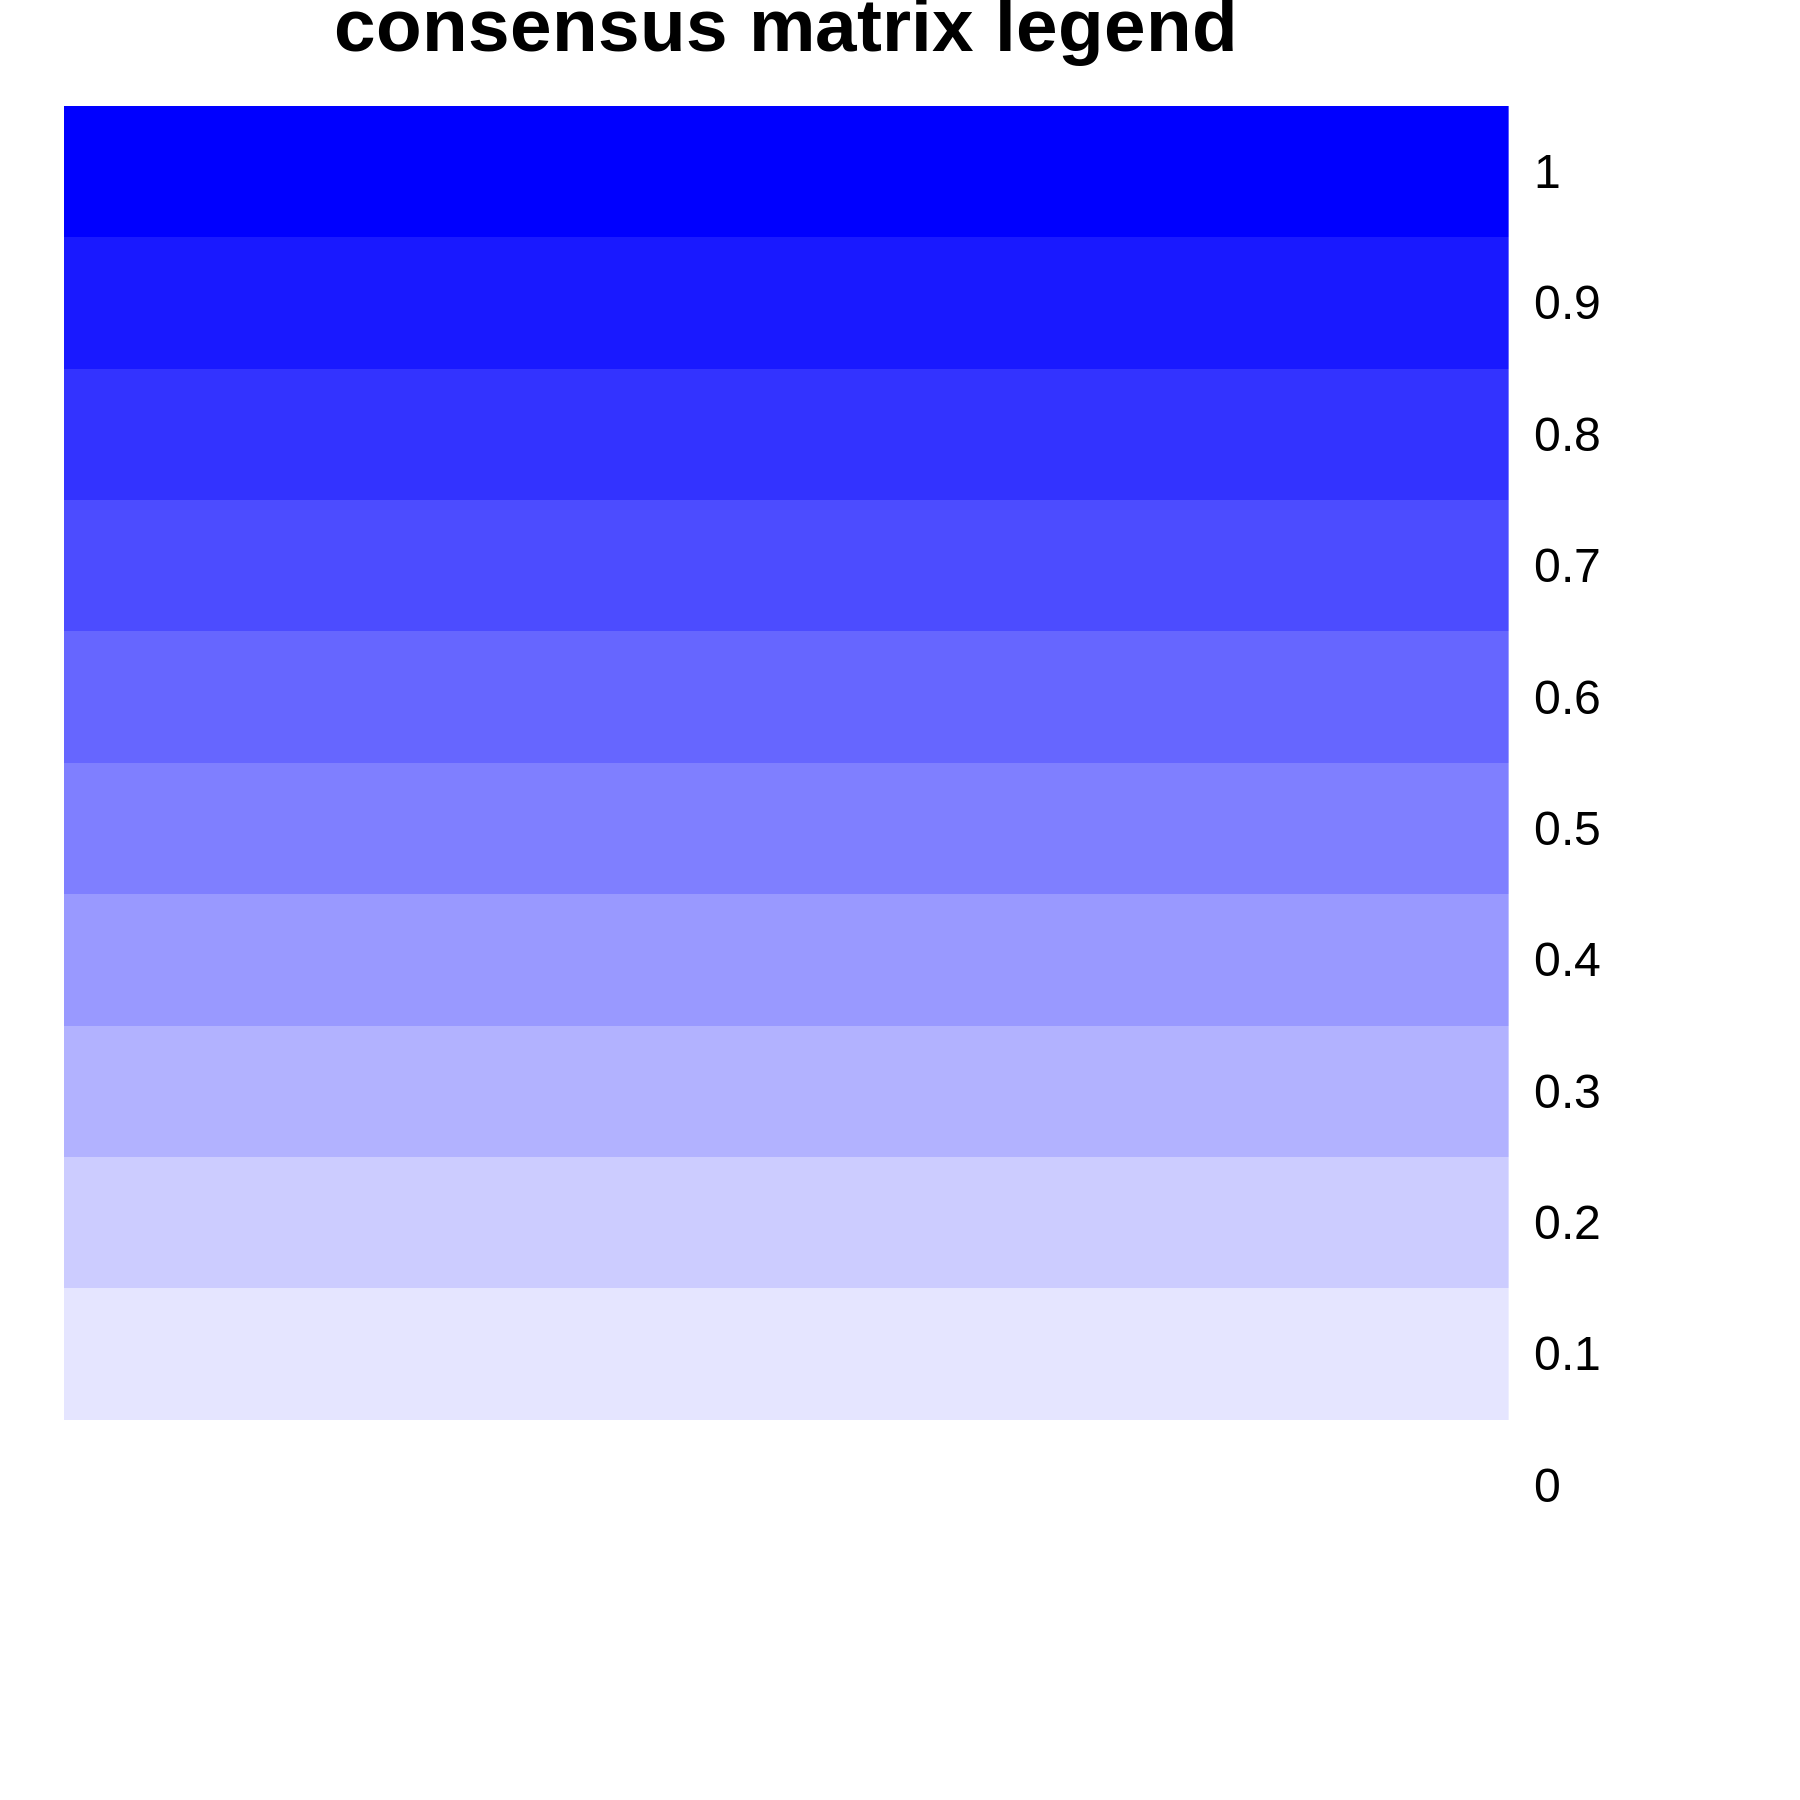

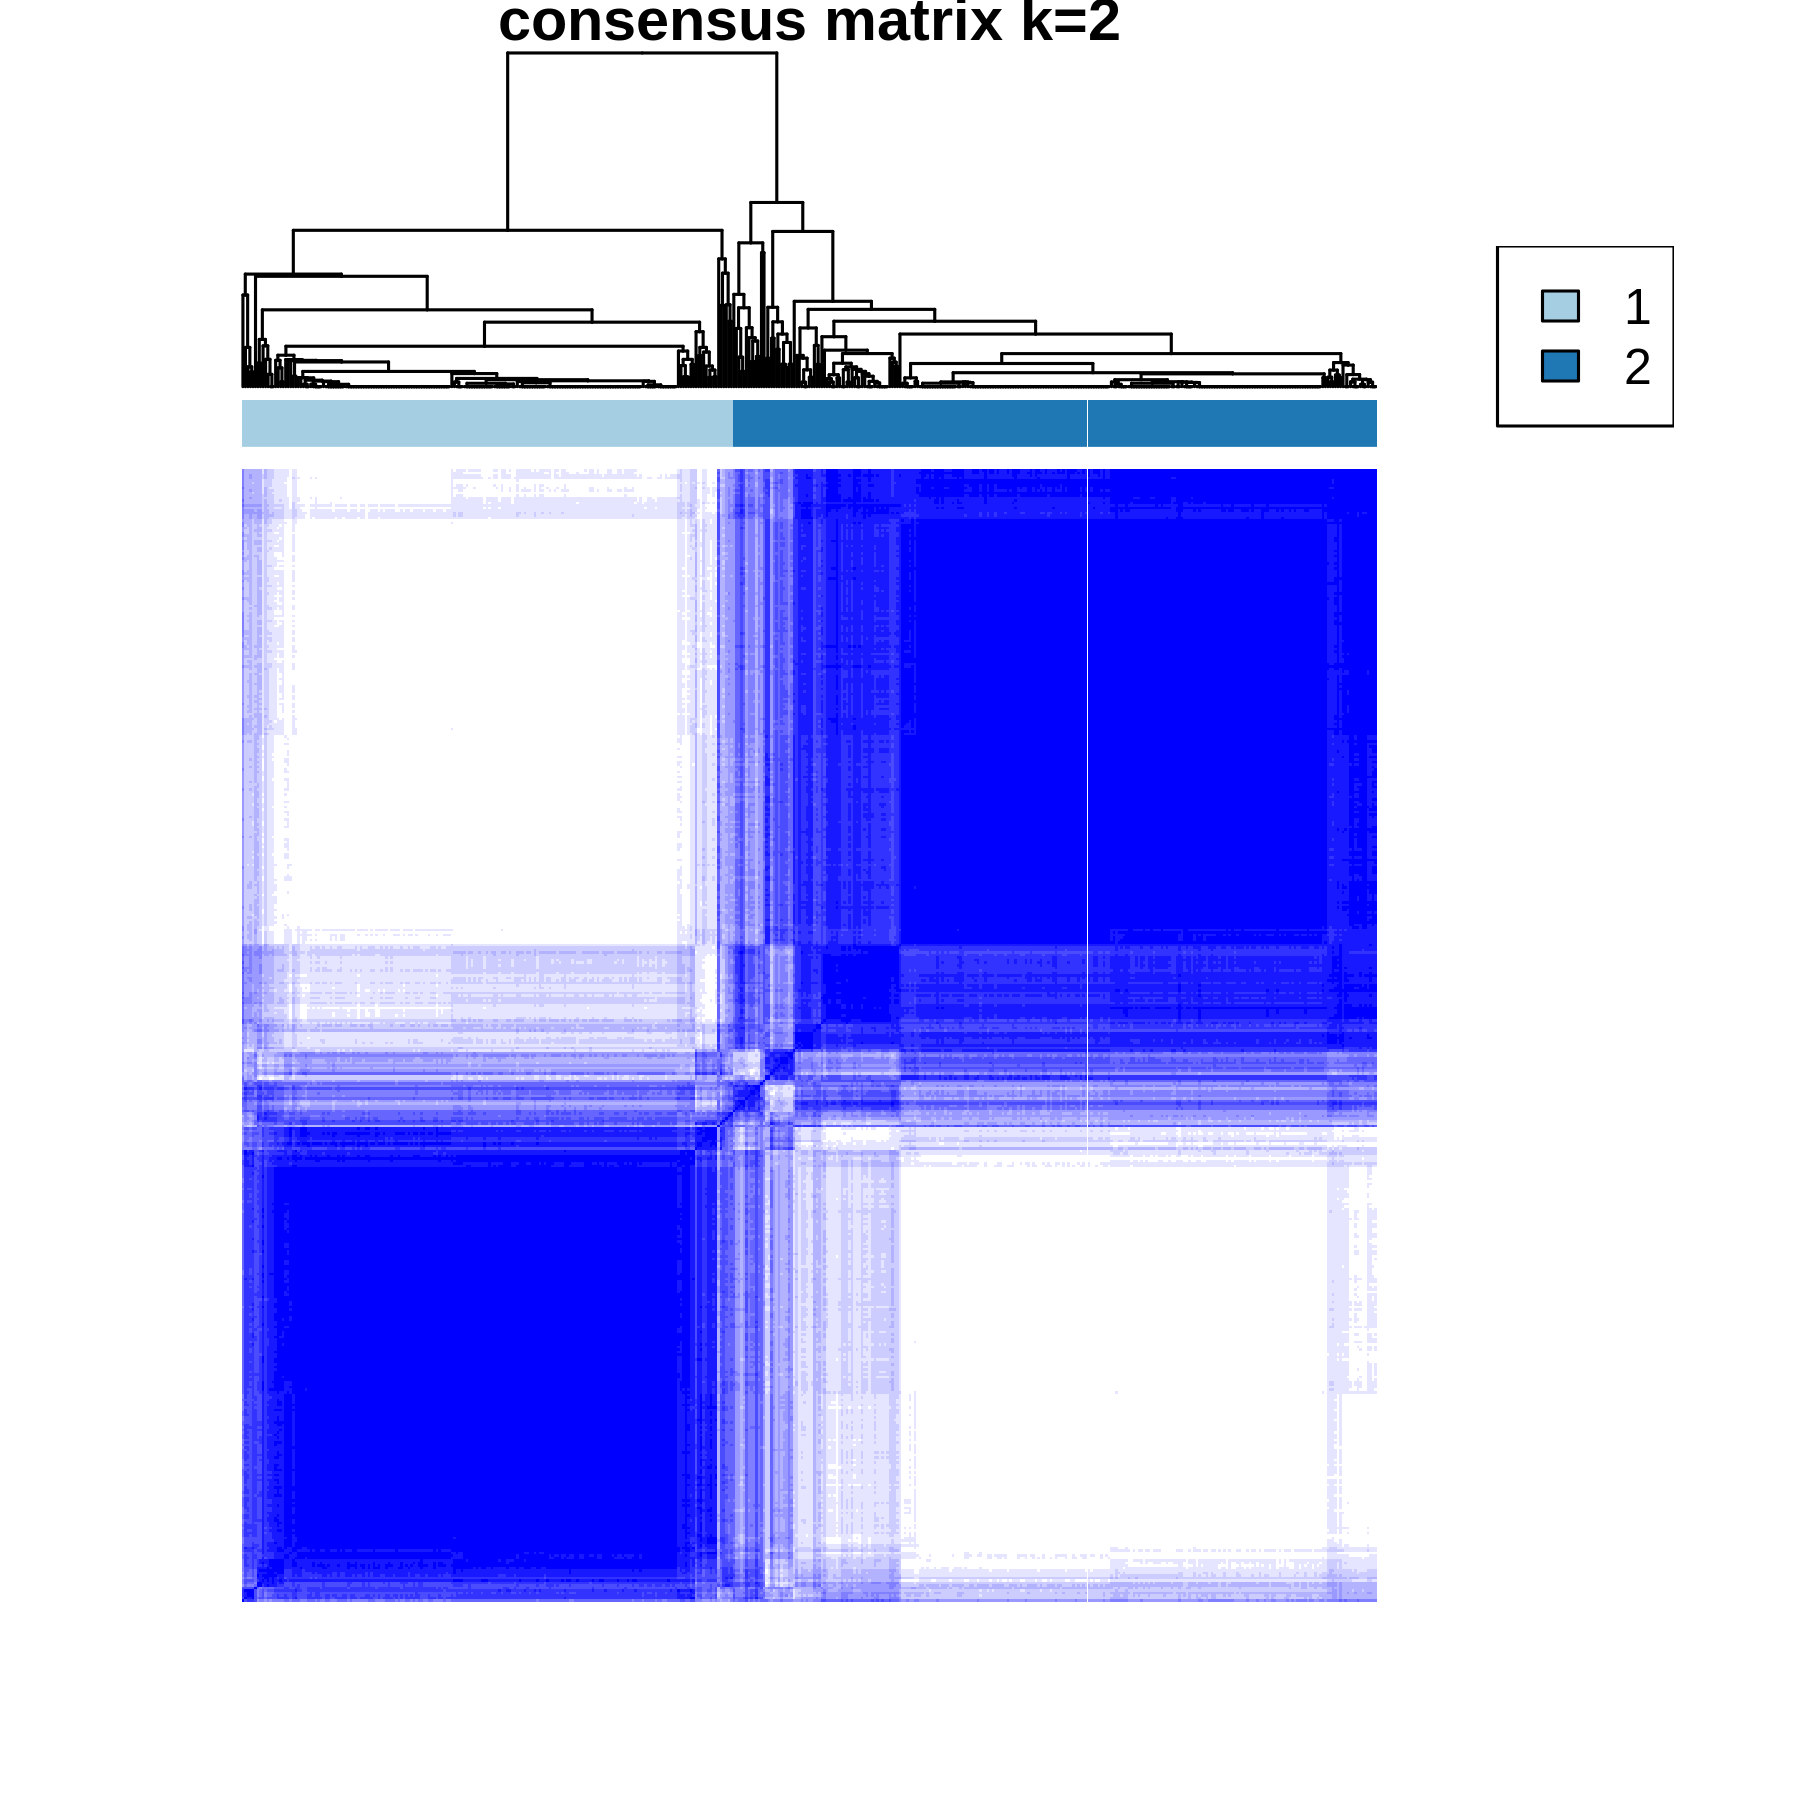

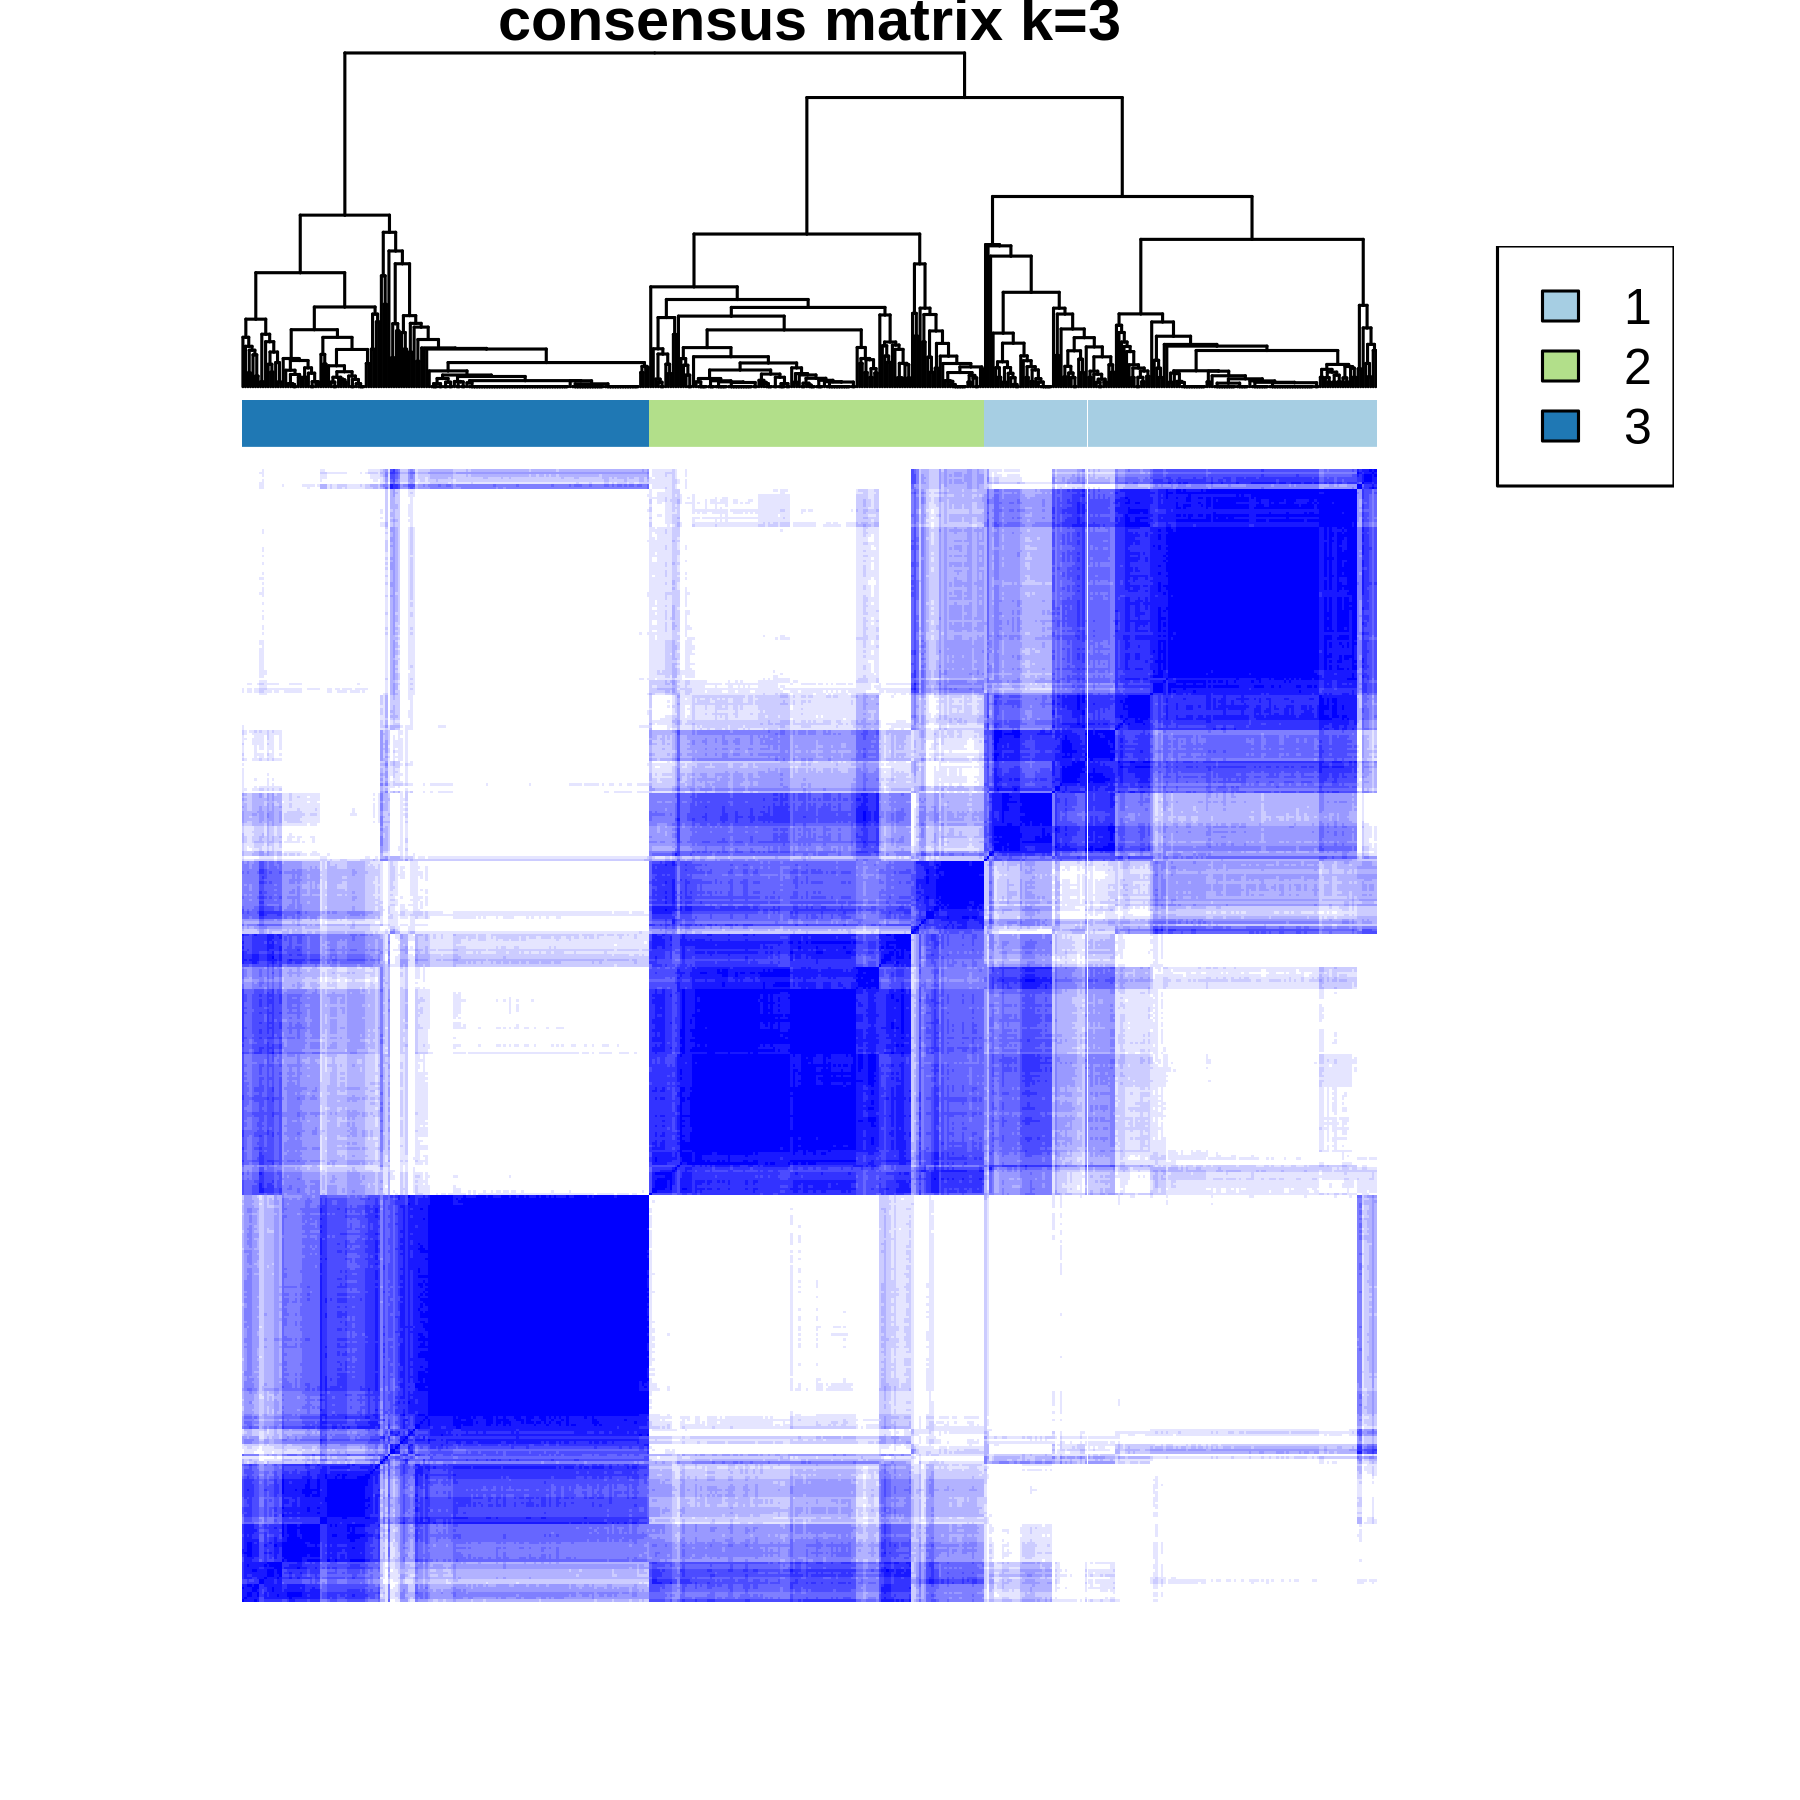

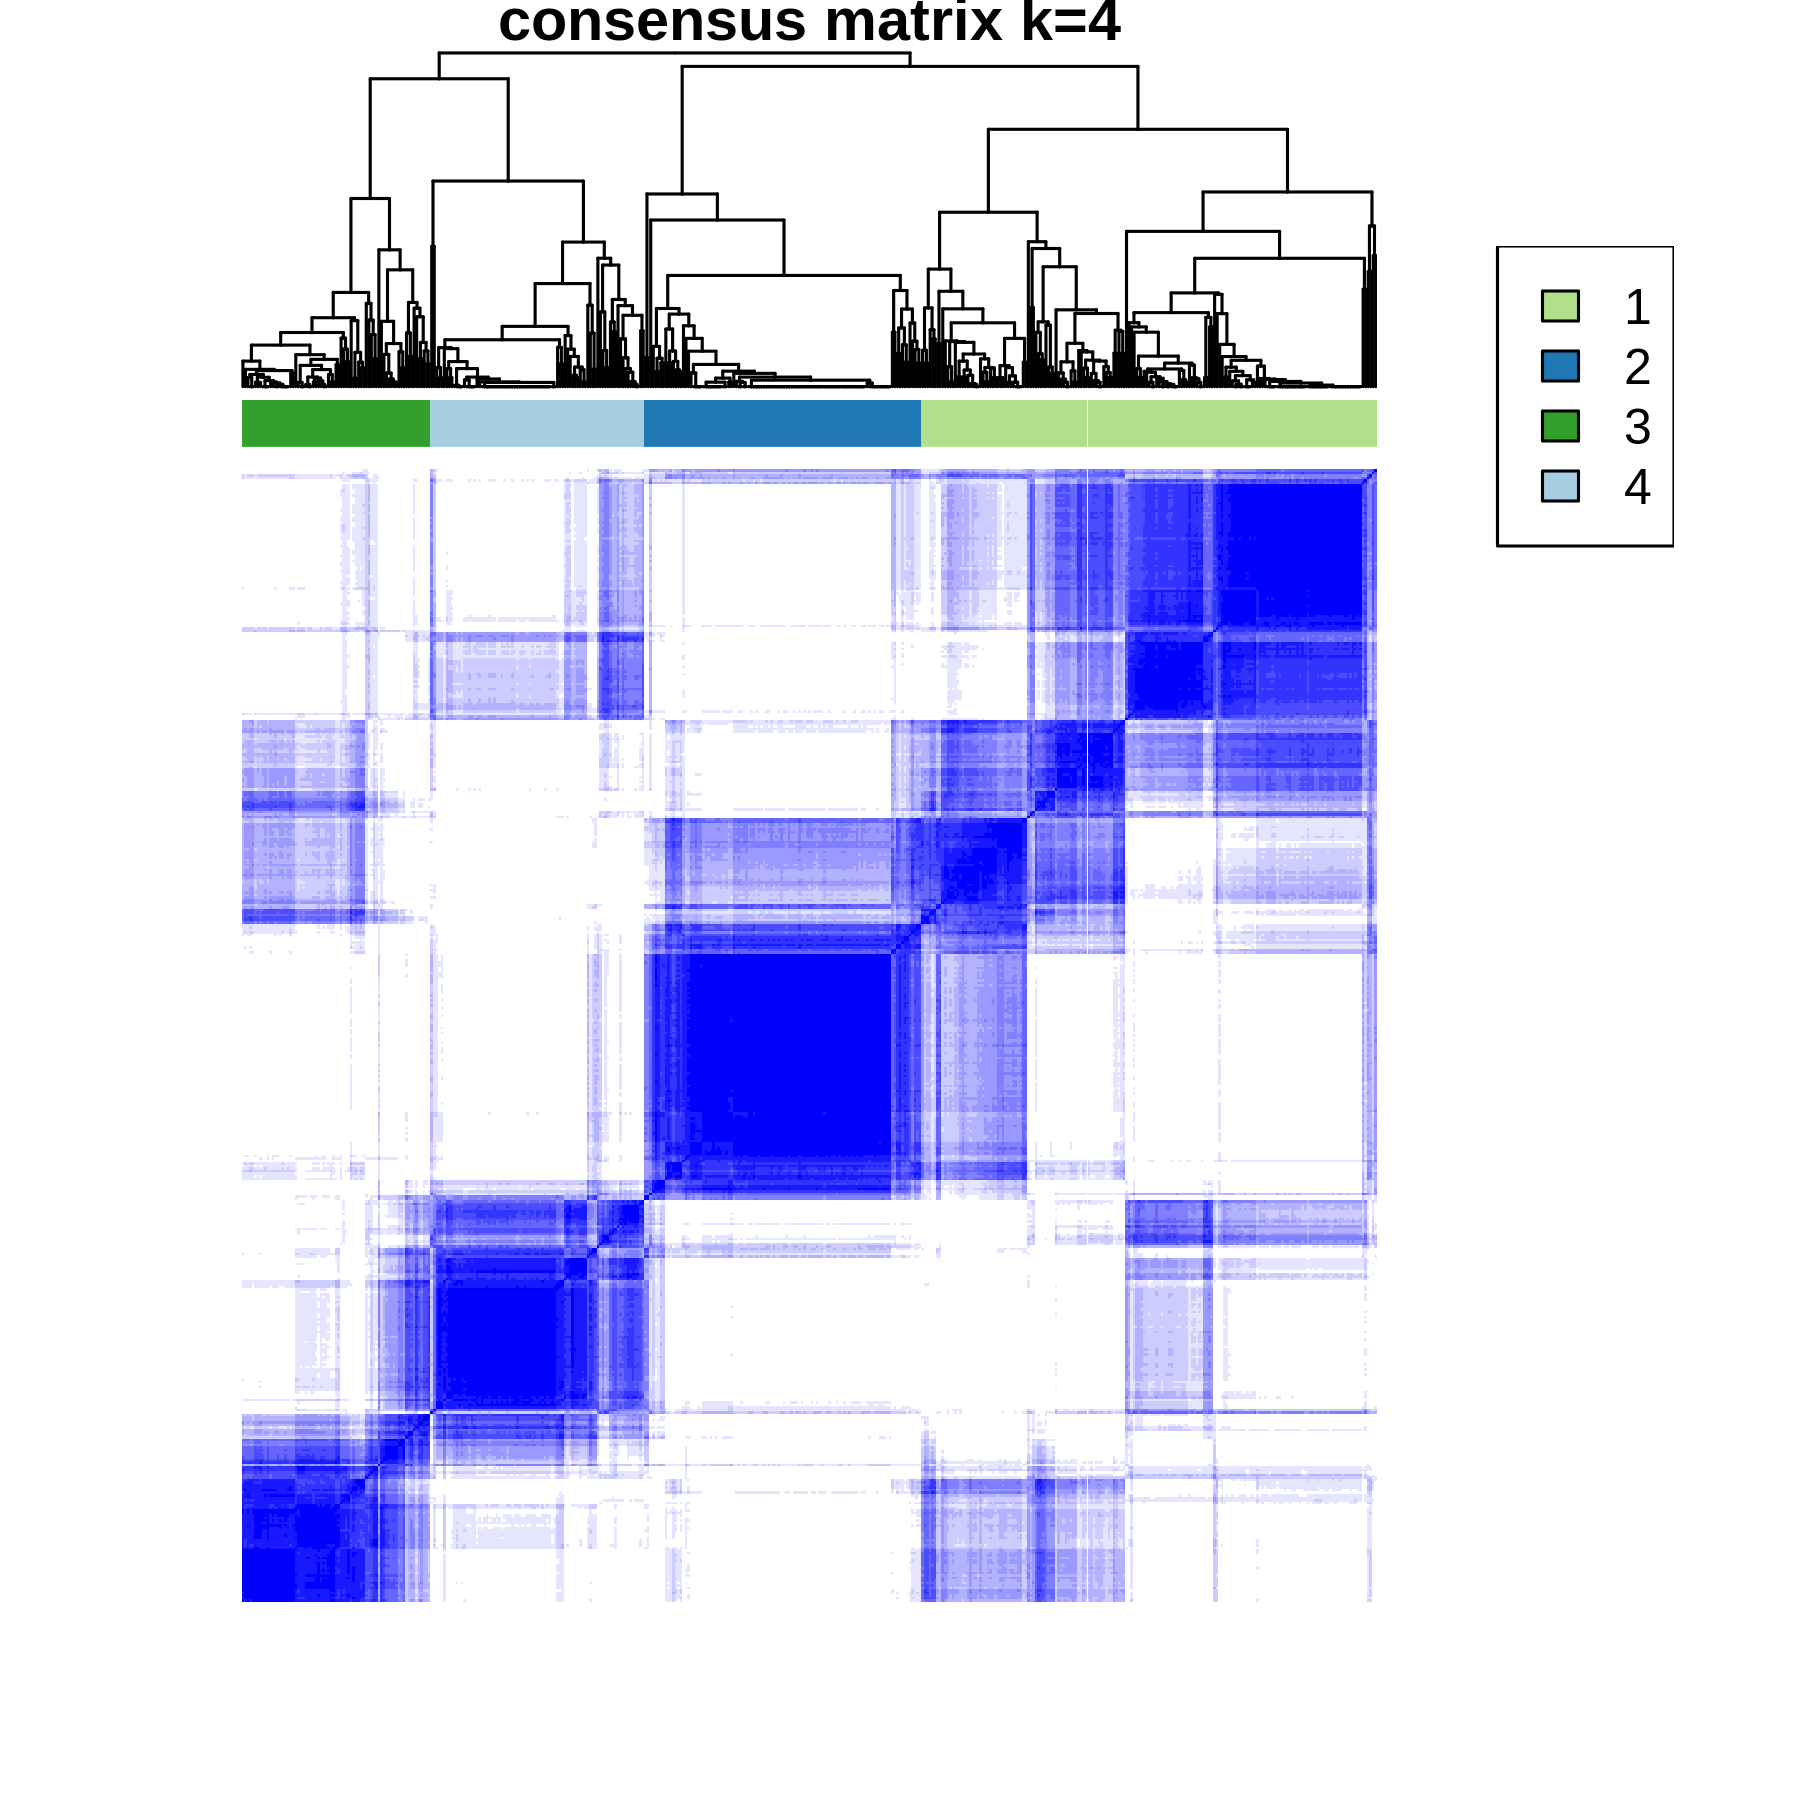

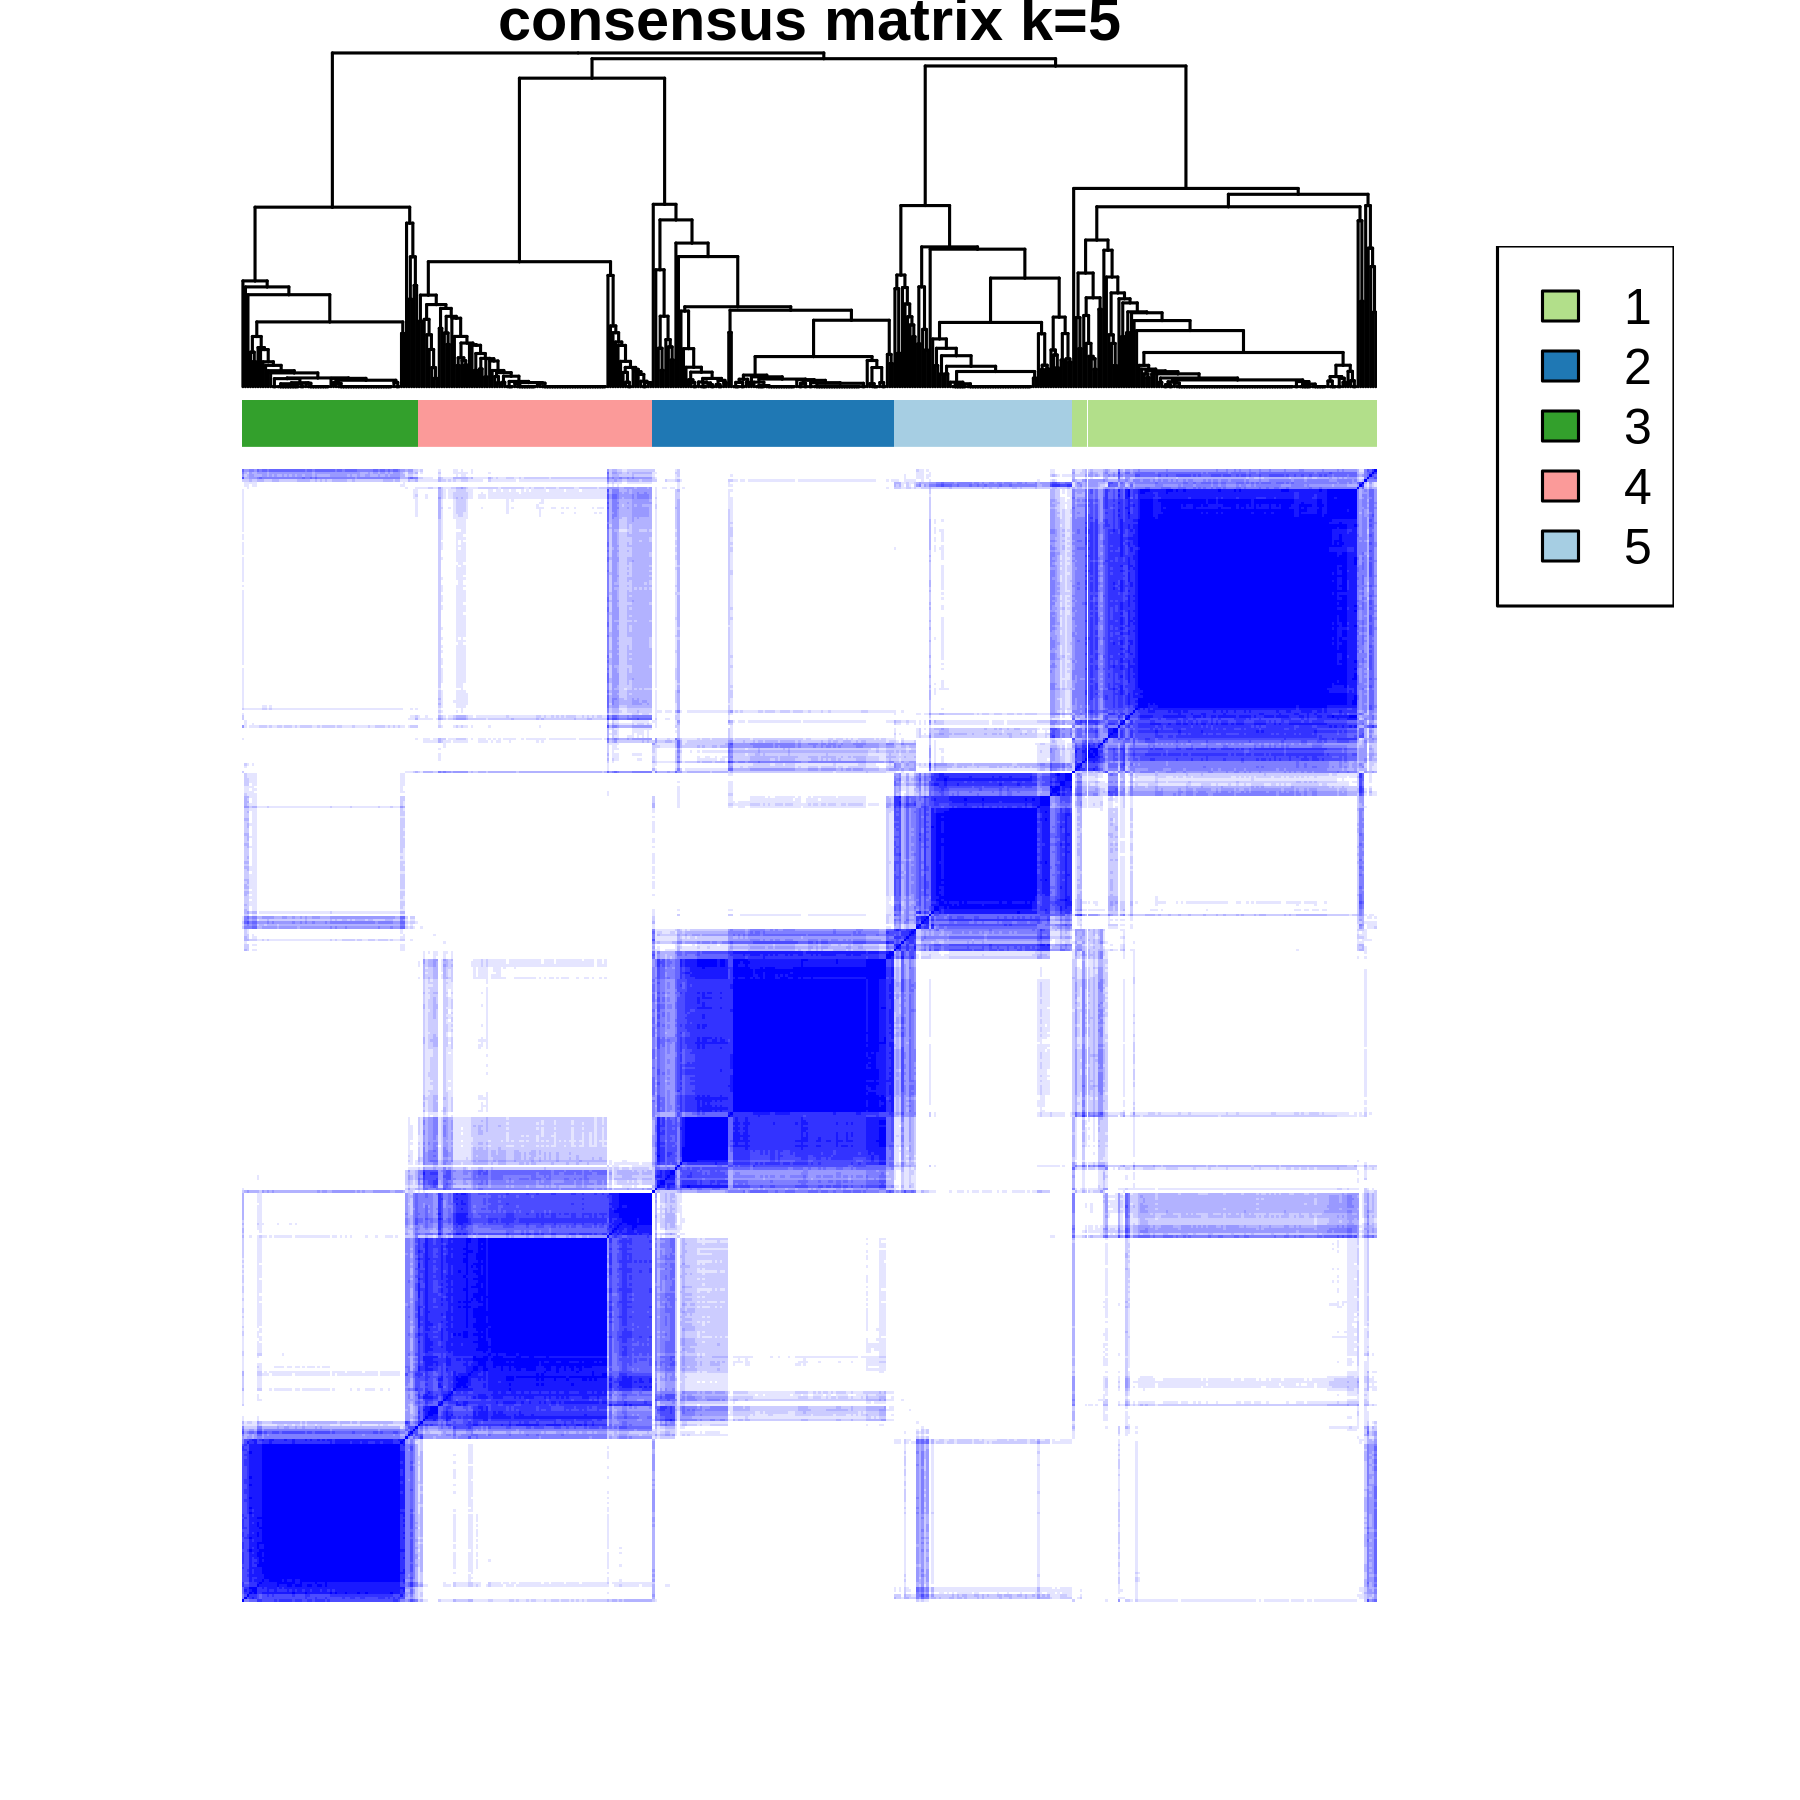

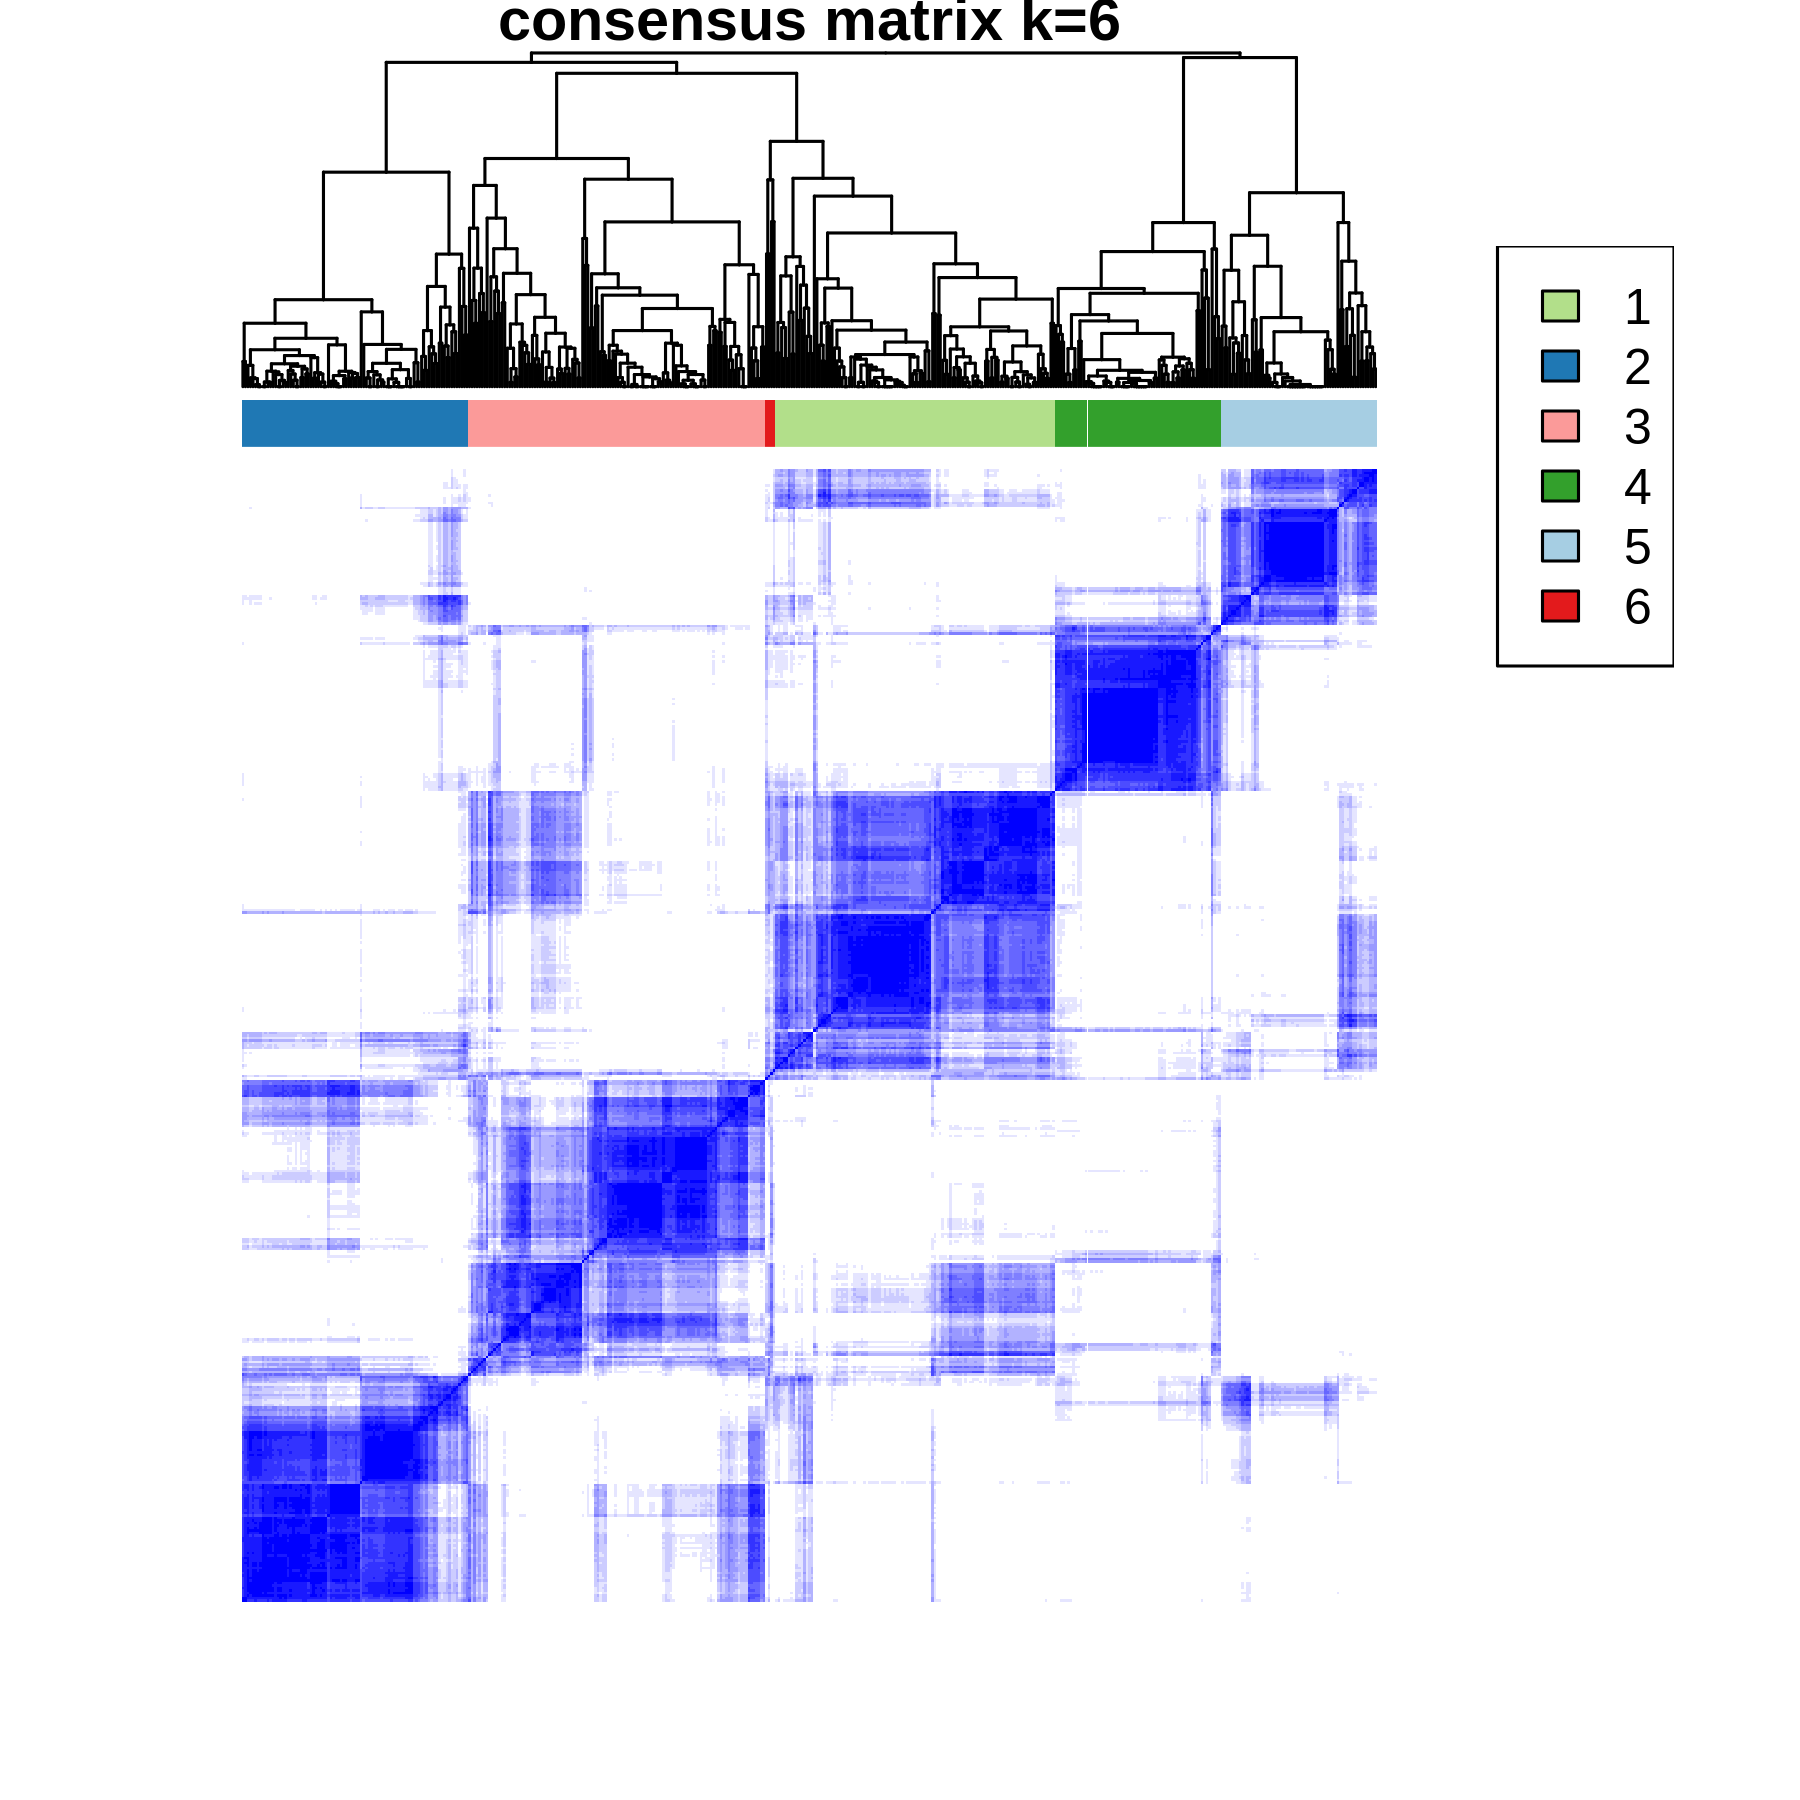

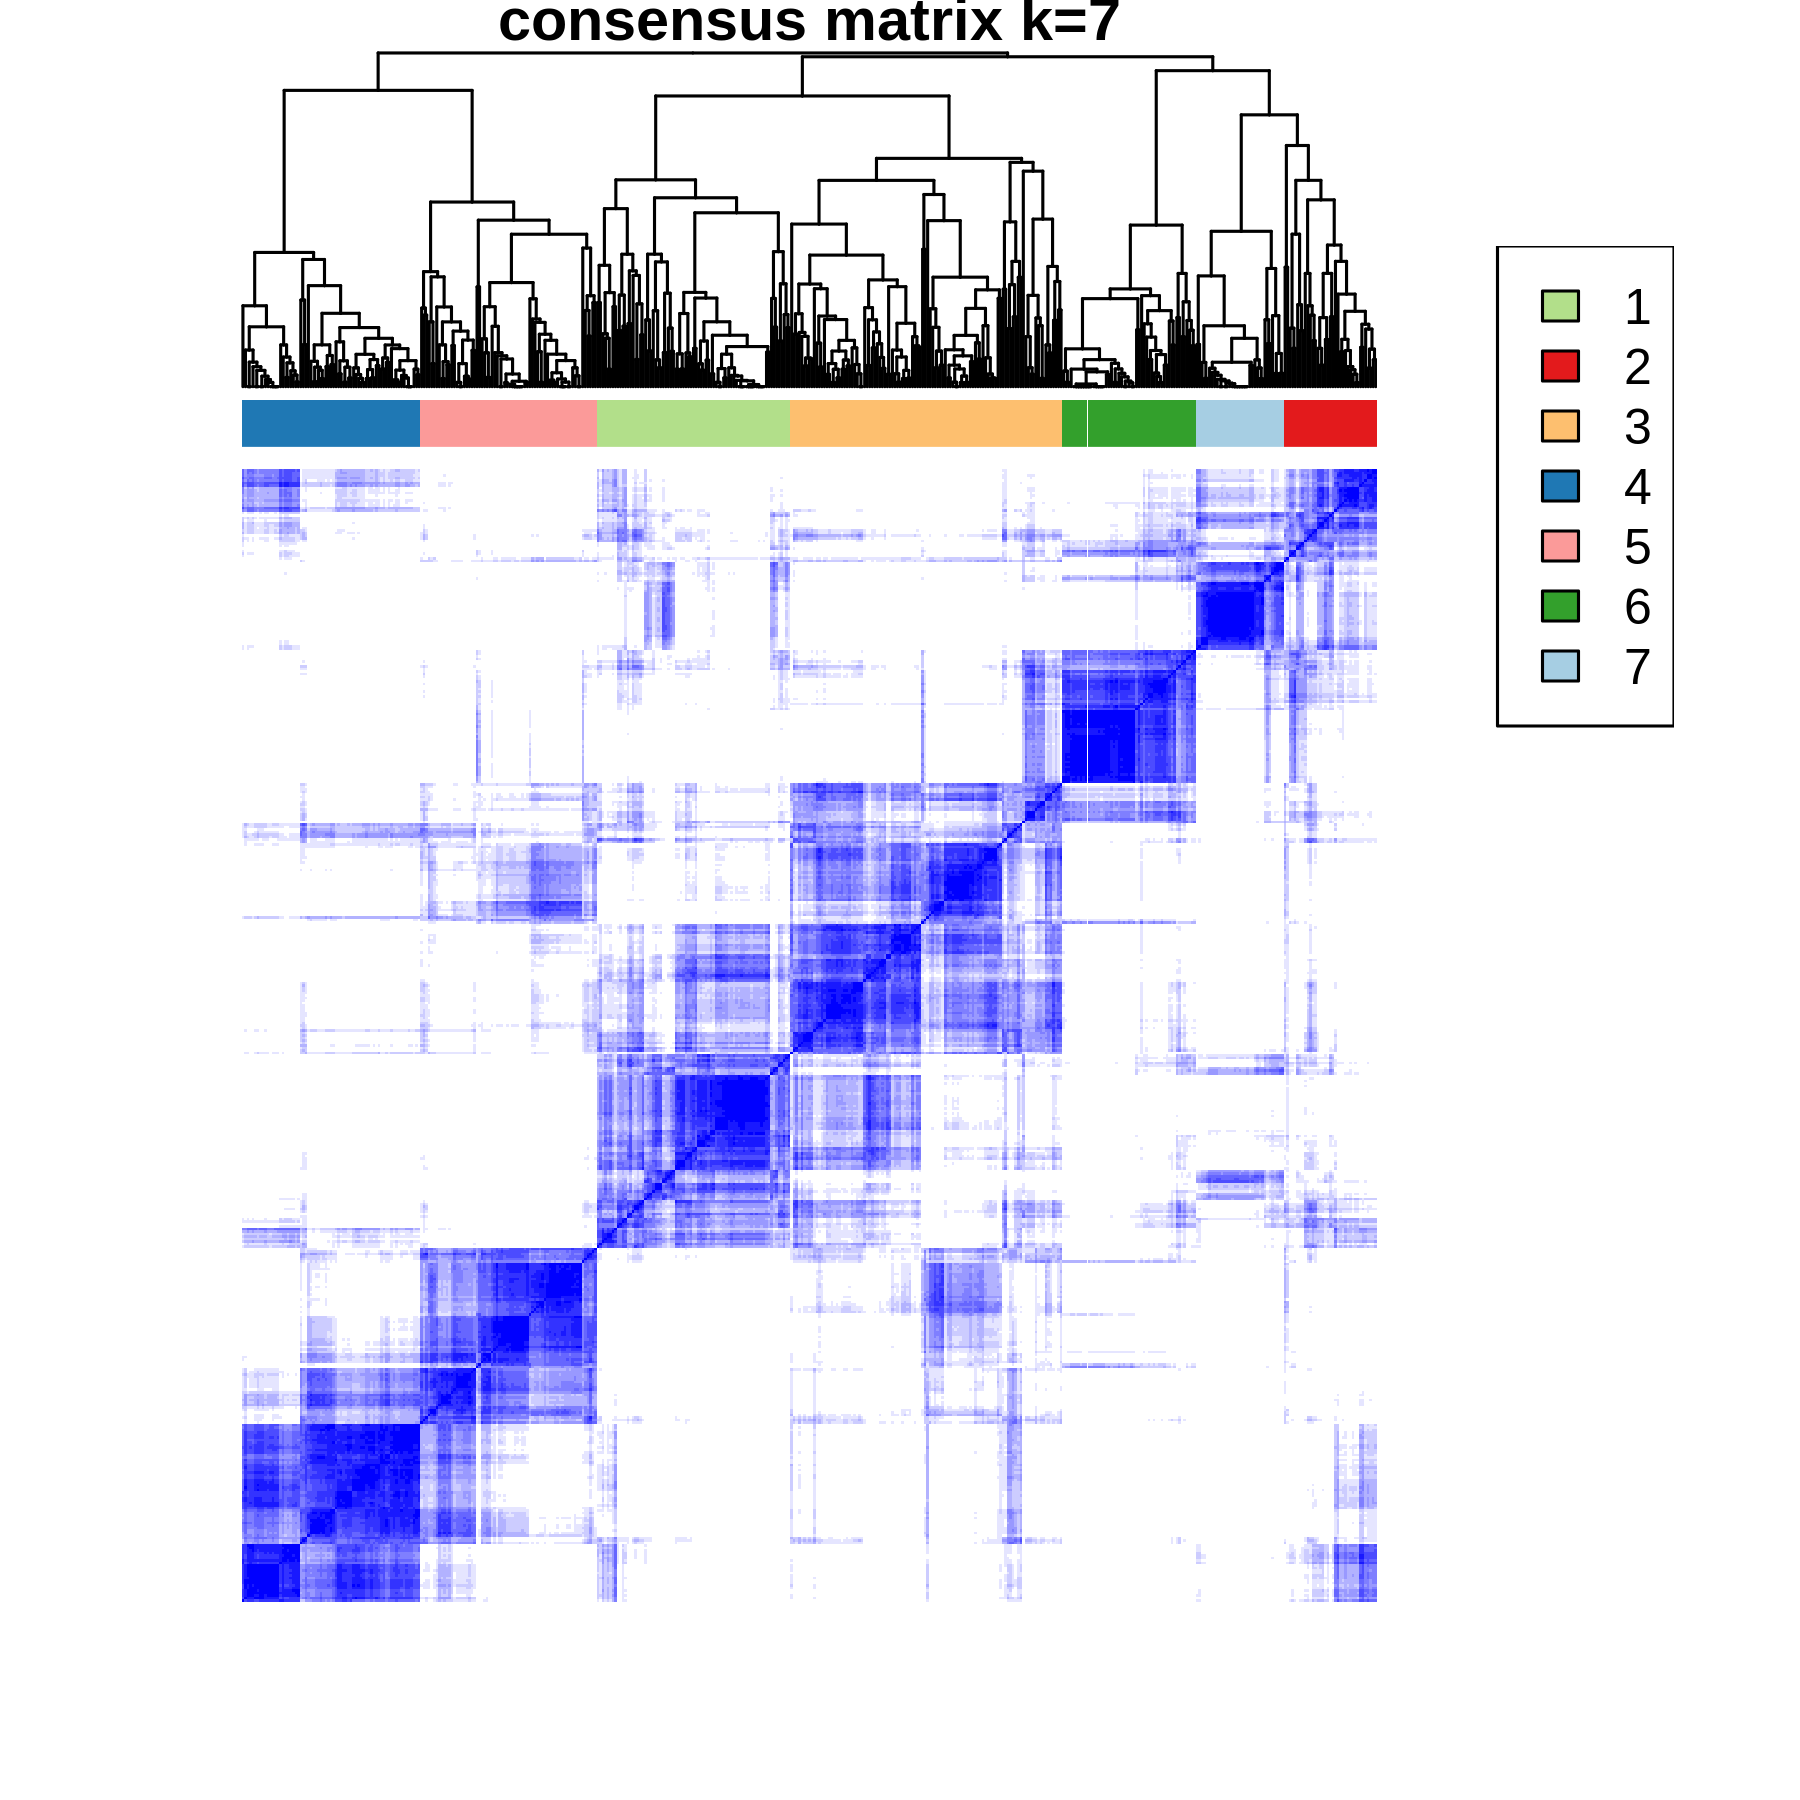

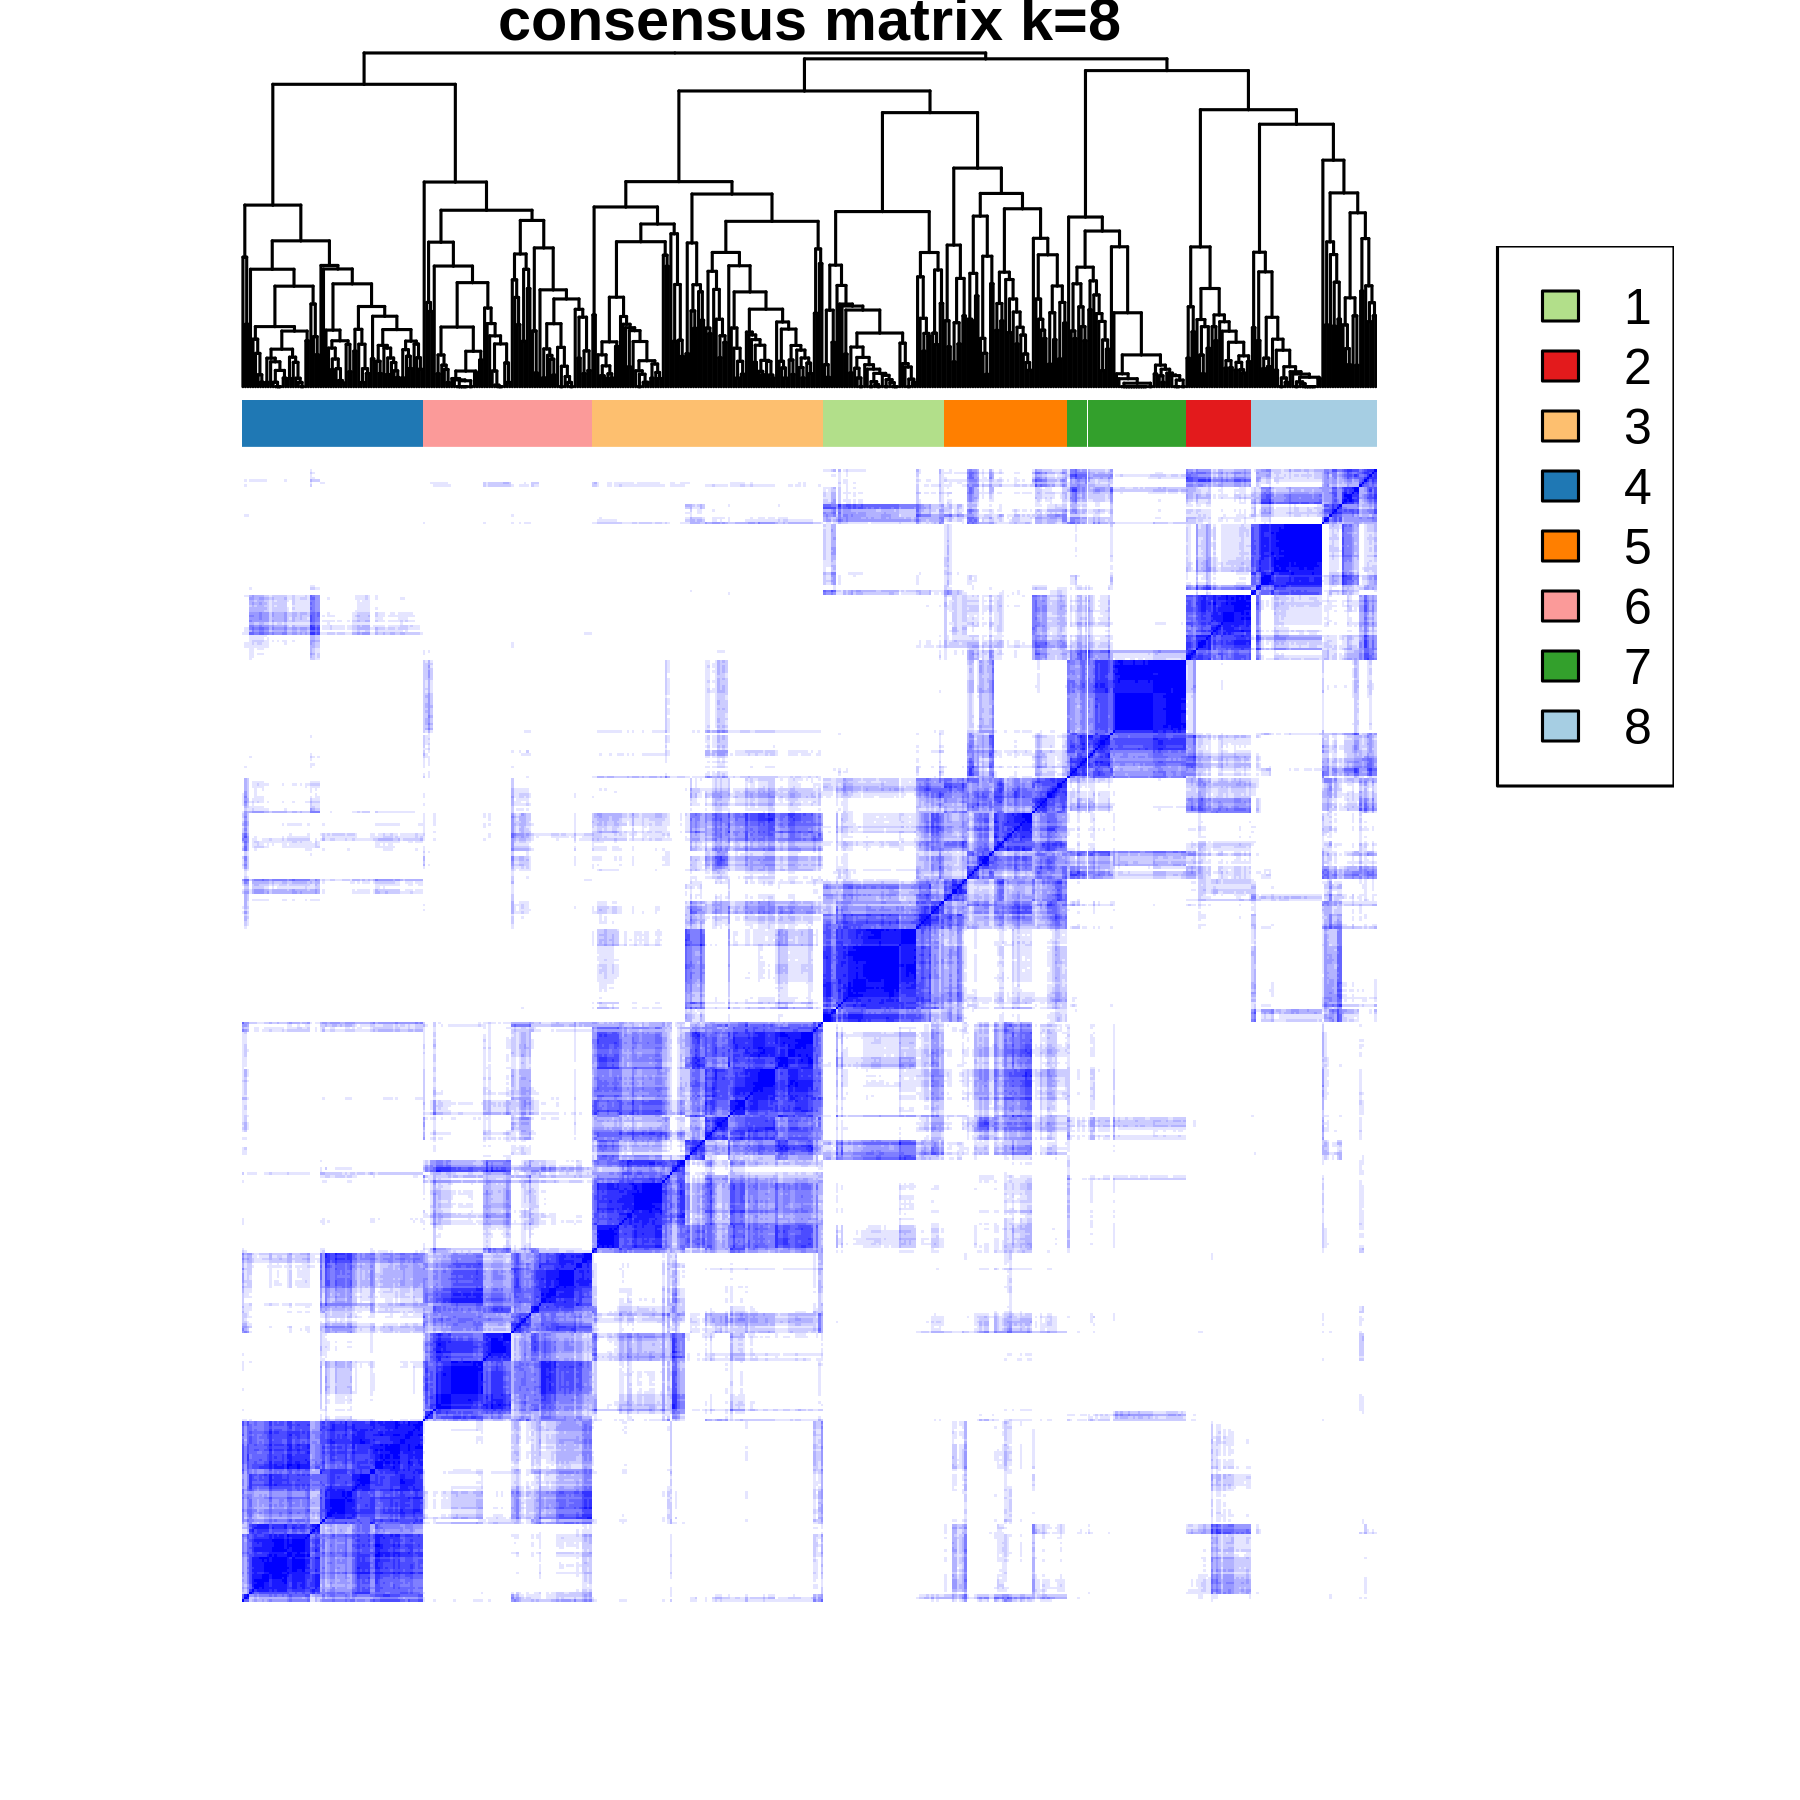

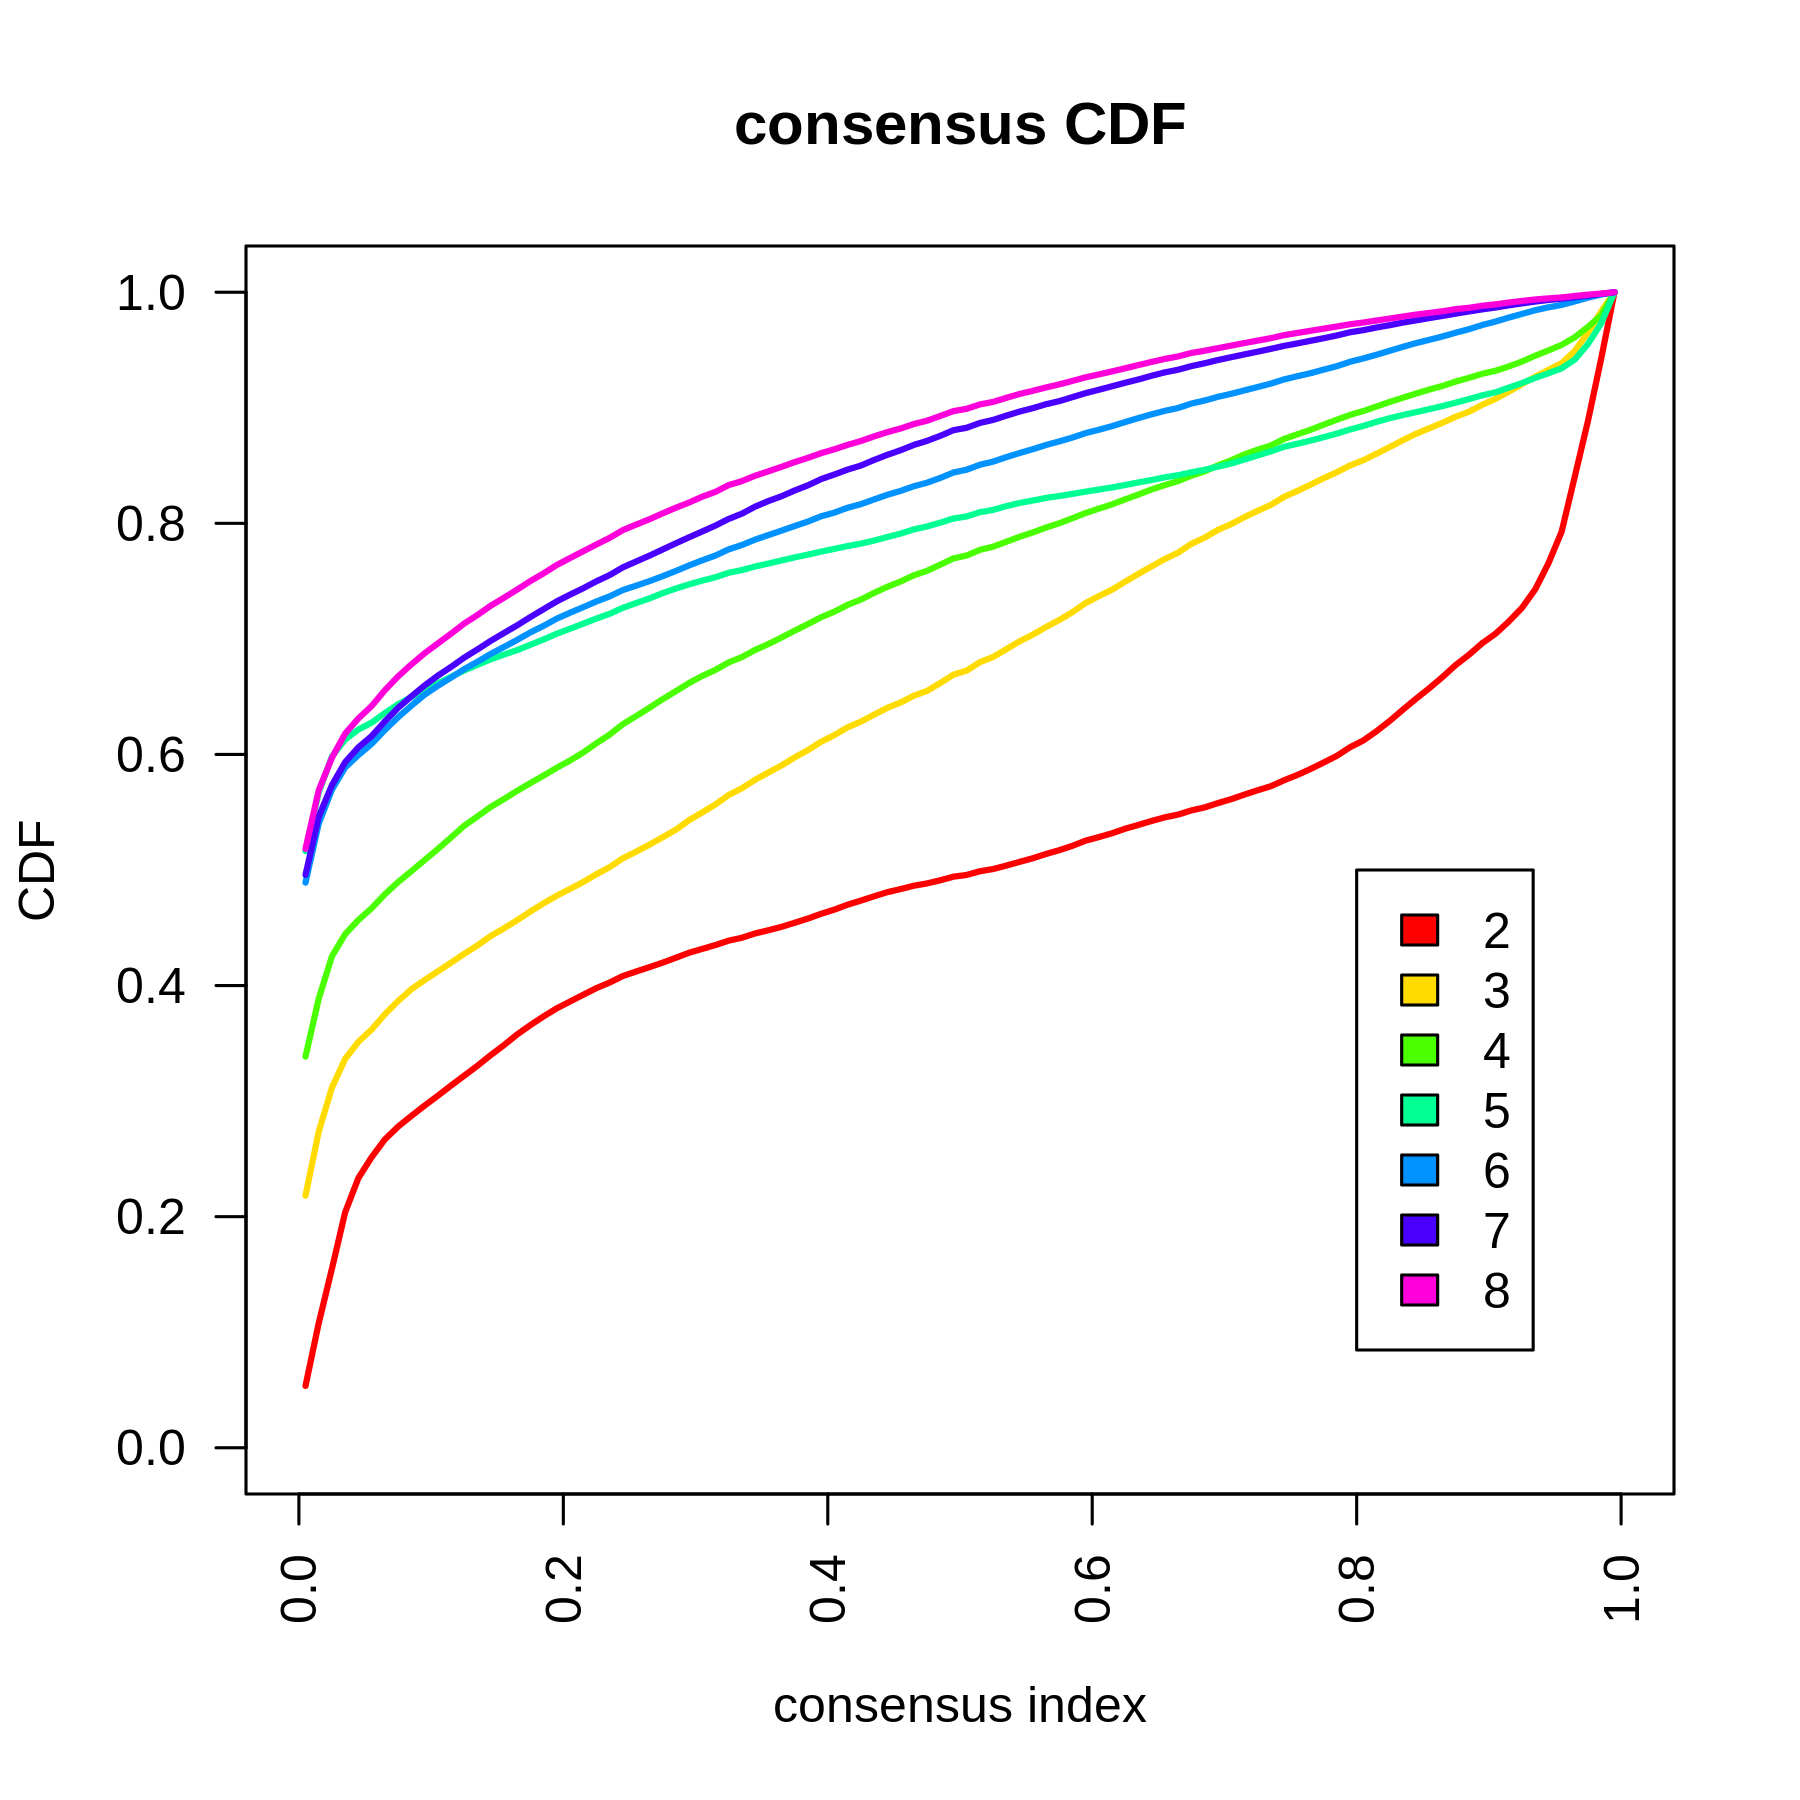

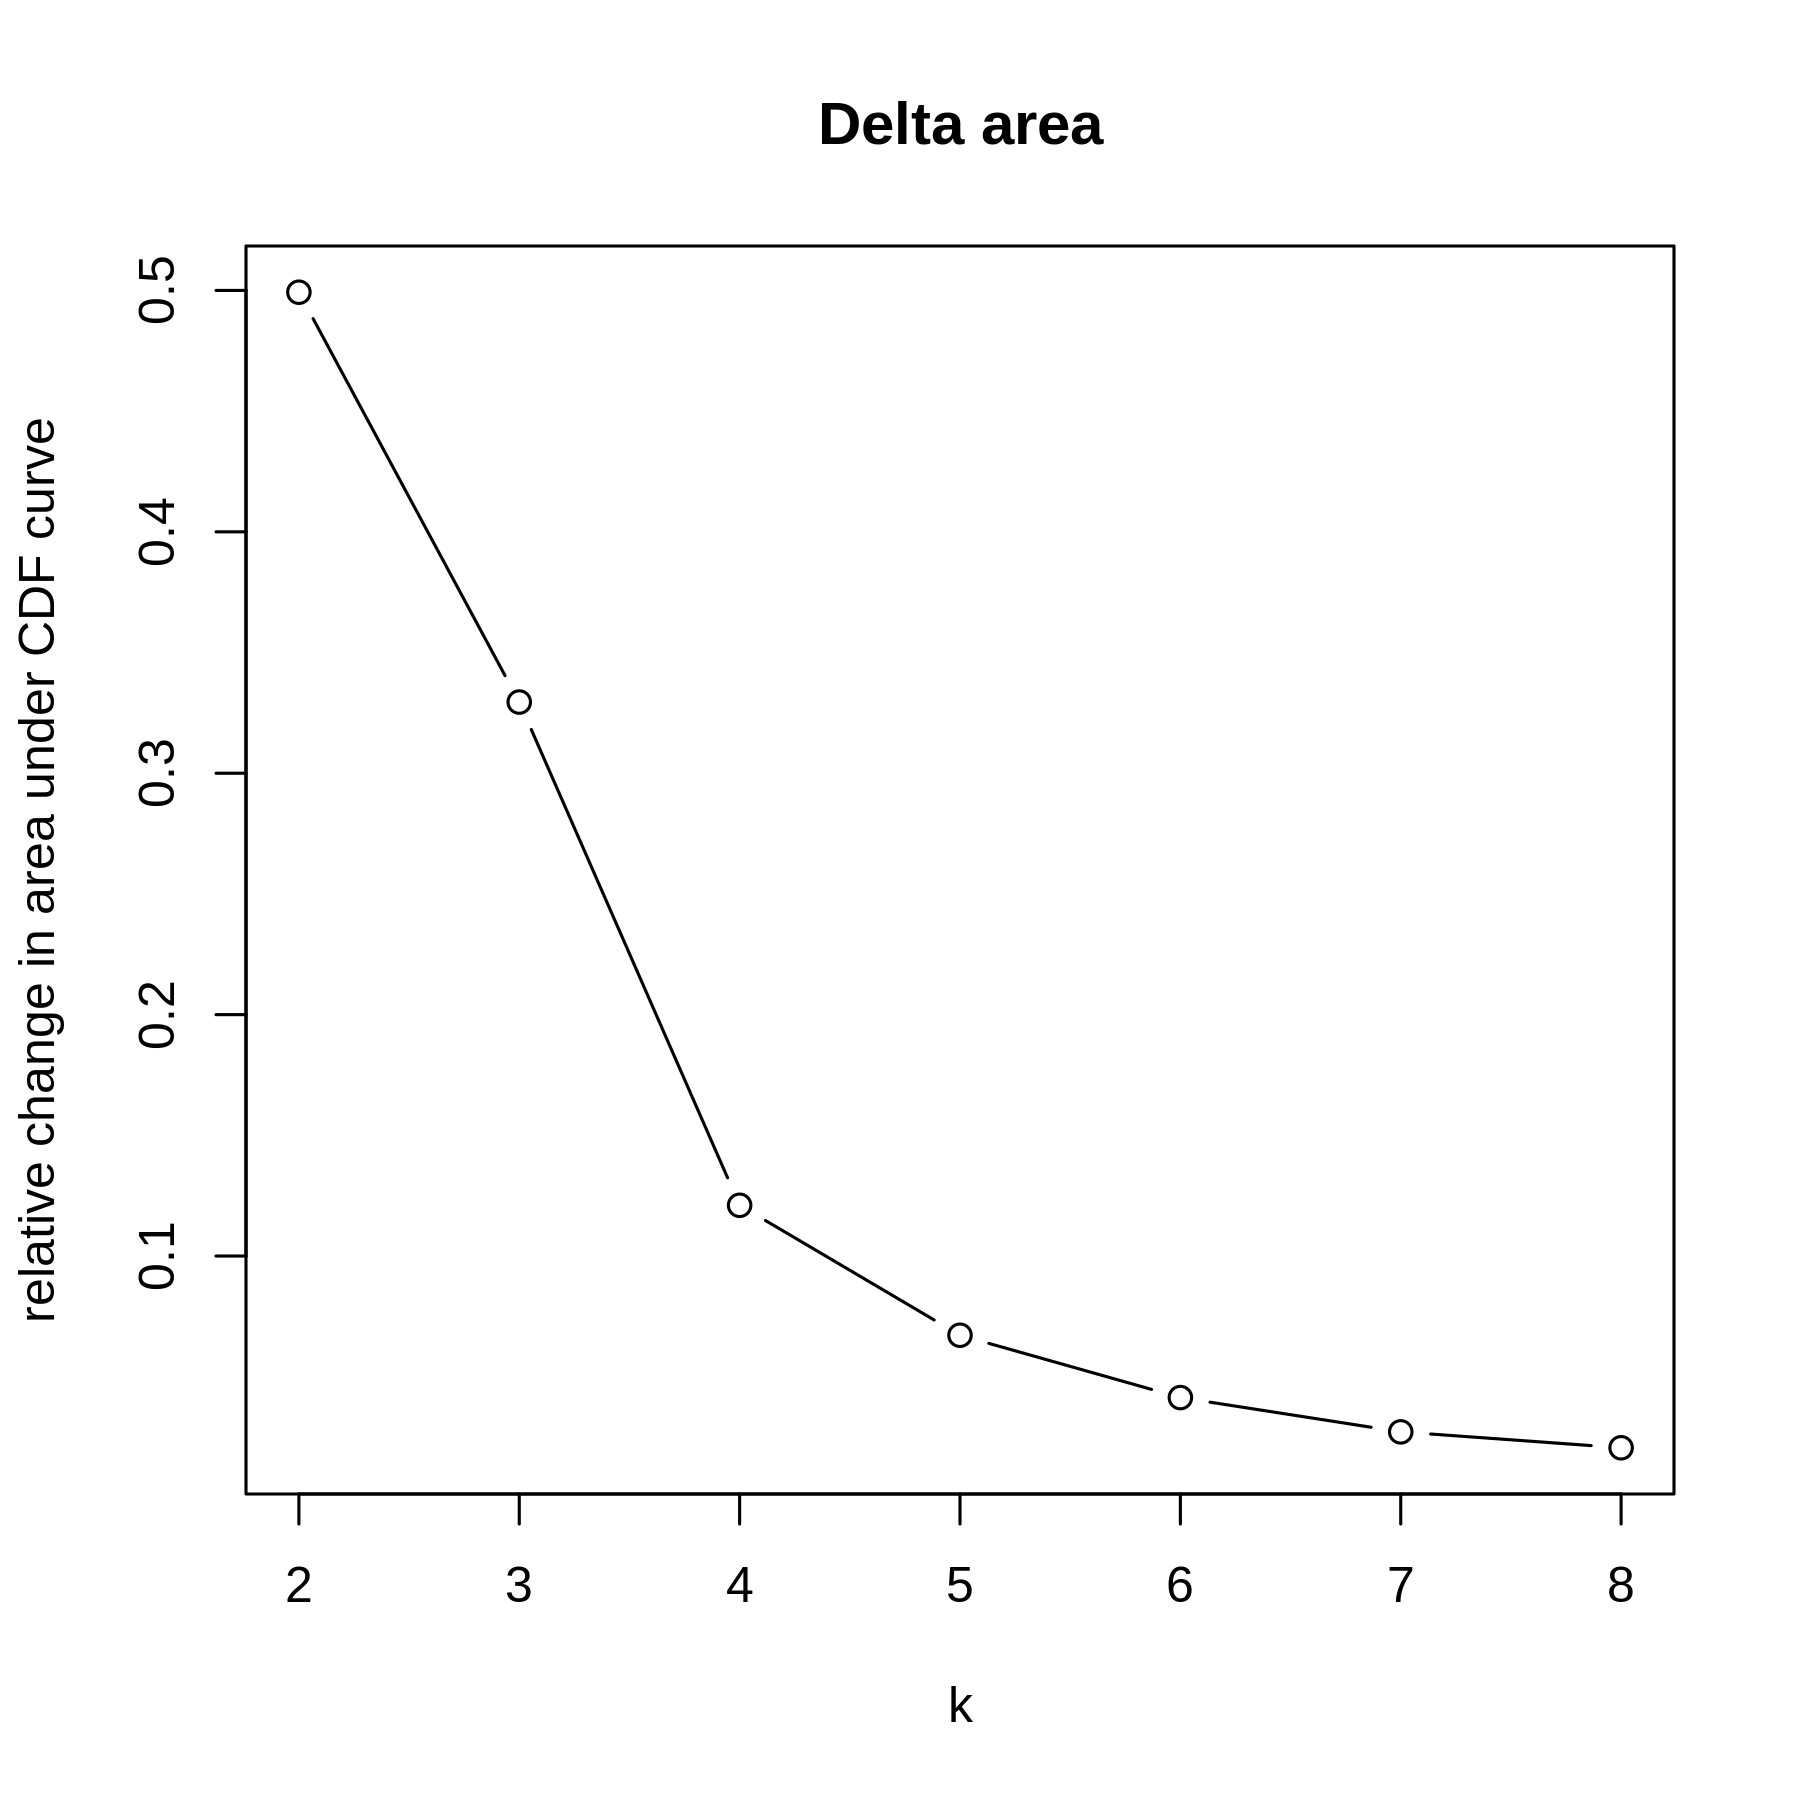

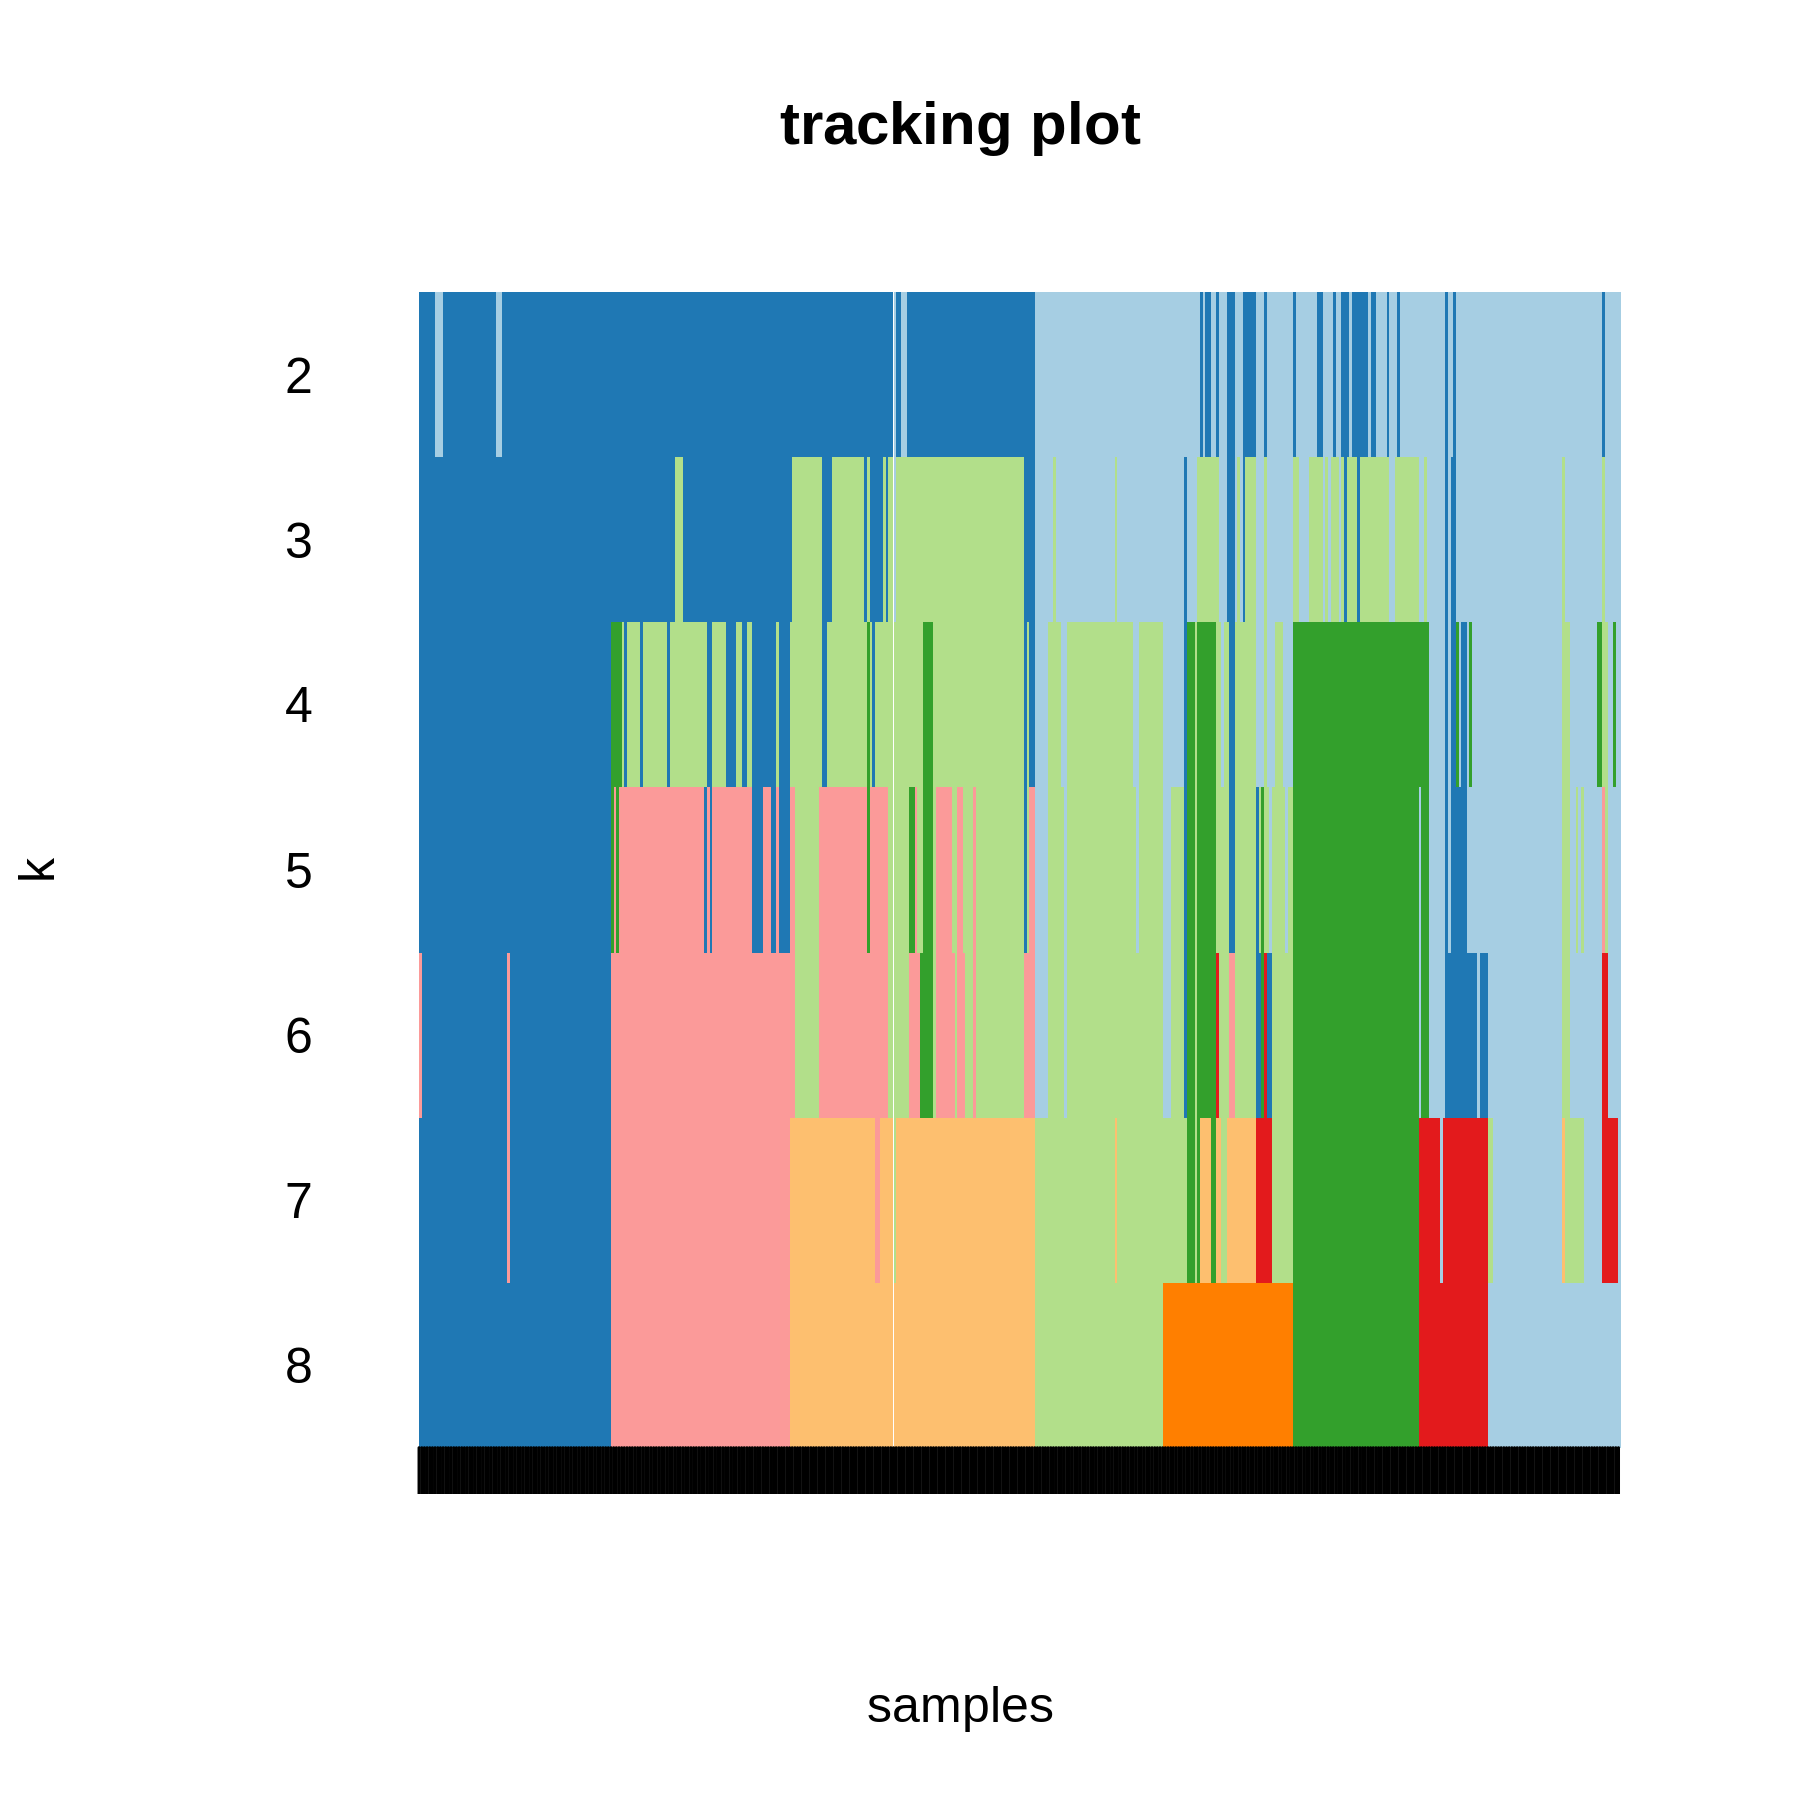

In [10]:
%%R -i Br,samples_name,factor_name  -o Cluster_results -w 6 -h 6 --units in -r 300

rownames(Br) = samples_name
colnames(Br) = factor_name
Cluster_results = ConsensusClusterPlus(t(apply(Br, 2, scale)), maxK = 8, rep = 100, pItem = 0.9, 
                             pFeature = 0.9, clusterAlg = "km", distance = "euclidean",seed = 2314)



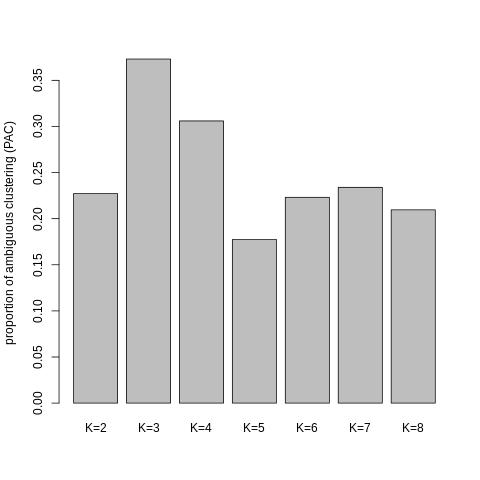

In [11]:

%%R -i Cluster_results

threshold = 0.8
cc_score = c()

for (i in seq(2,8)){
    x = (Cluster_results[i][[1]]$consensusMatrix)
    #print(x)
    cc_score = c(cc_score, 1 - (length(x[x > threshold]) + length(x[x < (1- threshold)]))/length(x))
}

barplot(cc_score, ylab = 'proportion of ambiguous clustering (PAC)', names.arg=c("K=2","K=3","K=4","K=5","K=6","K=7","K=8"))



In [16]:
cluster_sele = 5  #selection of clusters

#list_labe = ["S2","S3","S1","S4","S5"] #Reorder the clusters. 
list_labe = ["S4","S2","S3","S5","S1"] #Reorder the clusters. 

colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation
#The number of clusters and order of clusters here only reflects the example we are providing, for different dataset, the orders should be defined by the users.

In [19]:
select_modules = matrix_factor_selected.columns.values  #Features are defined by following steps which shows difference between different states

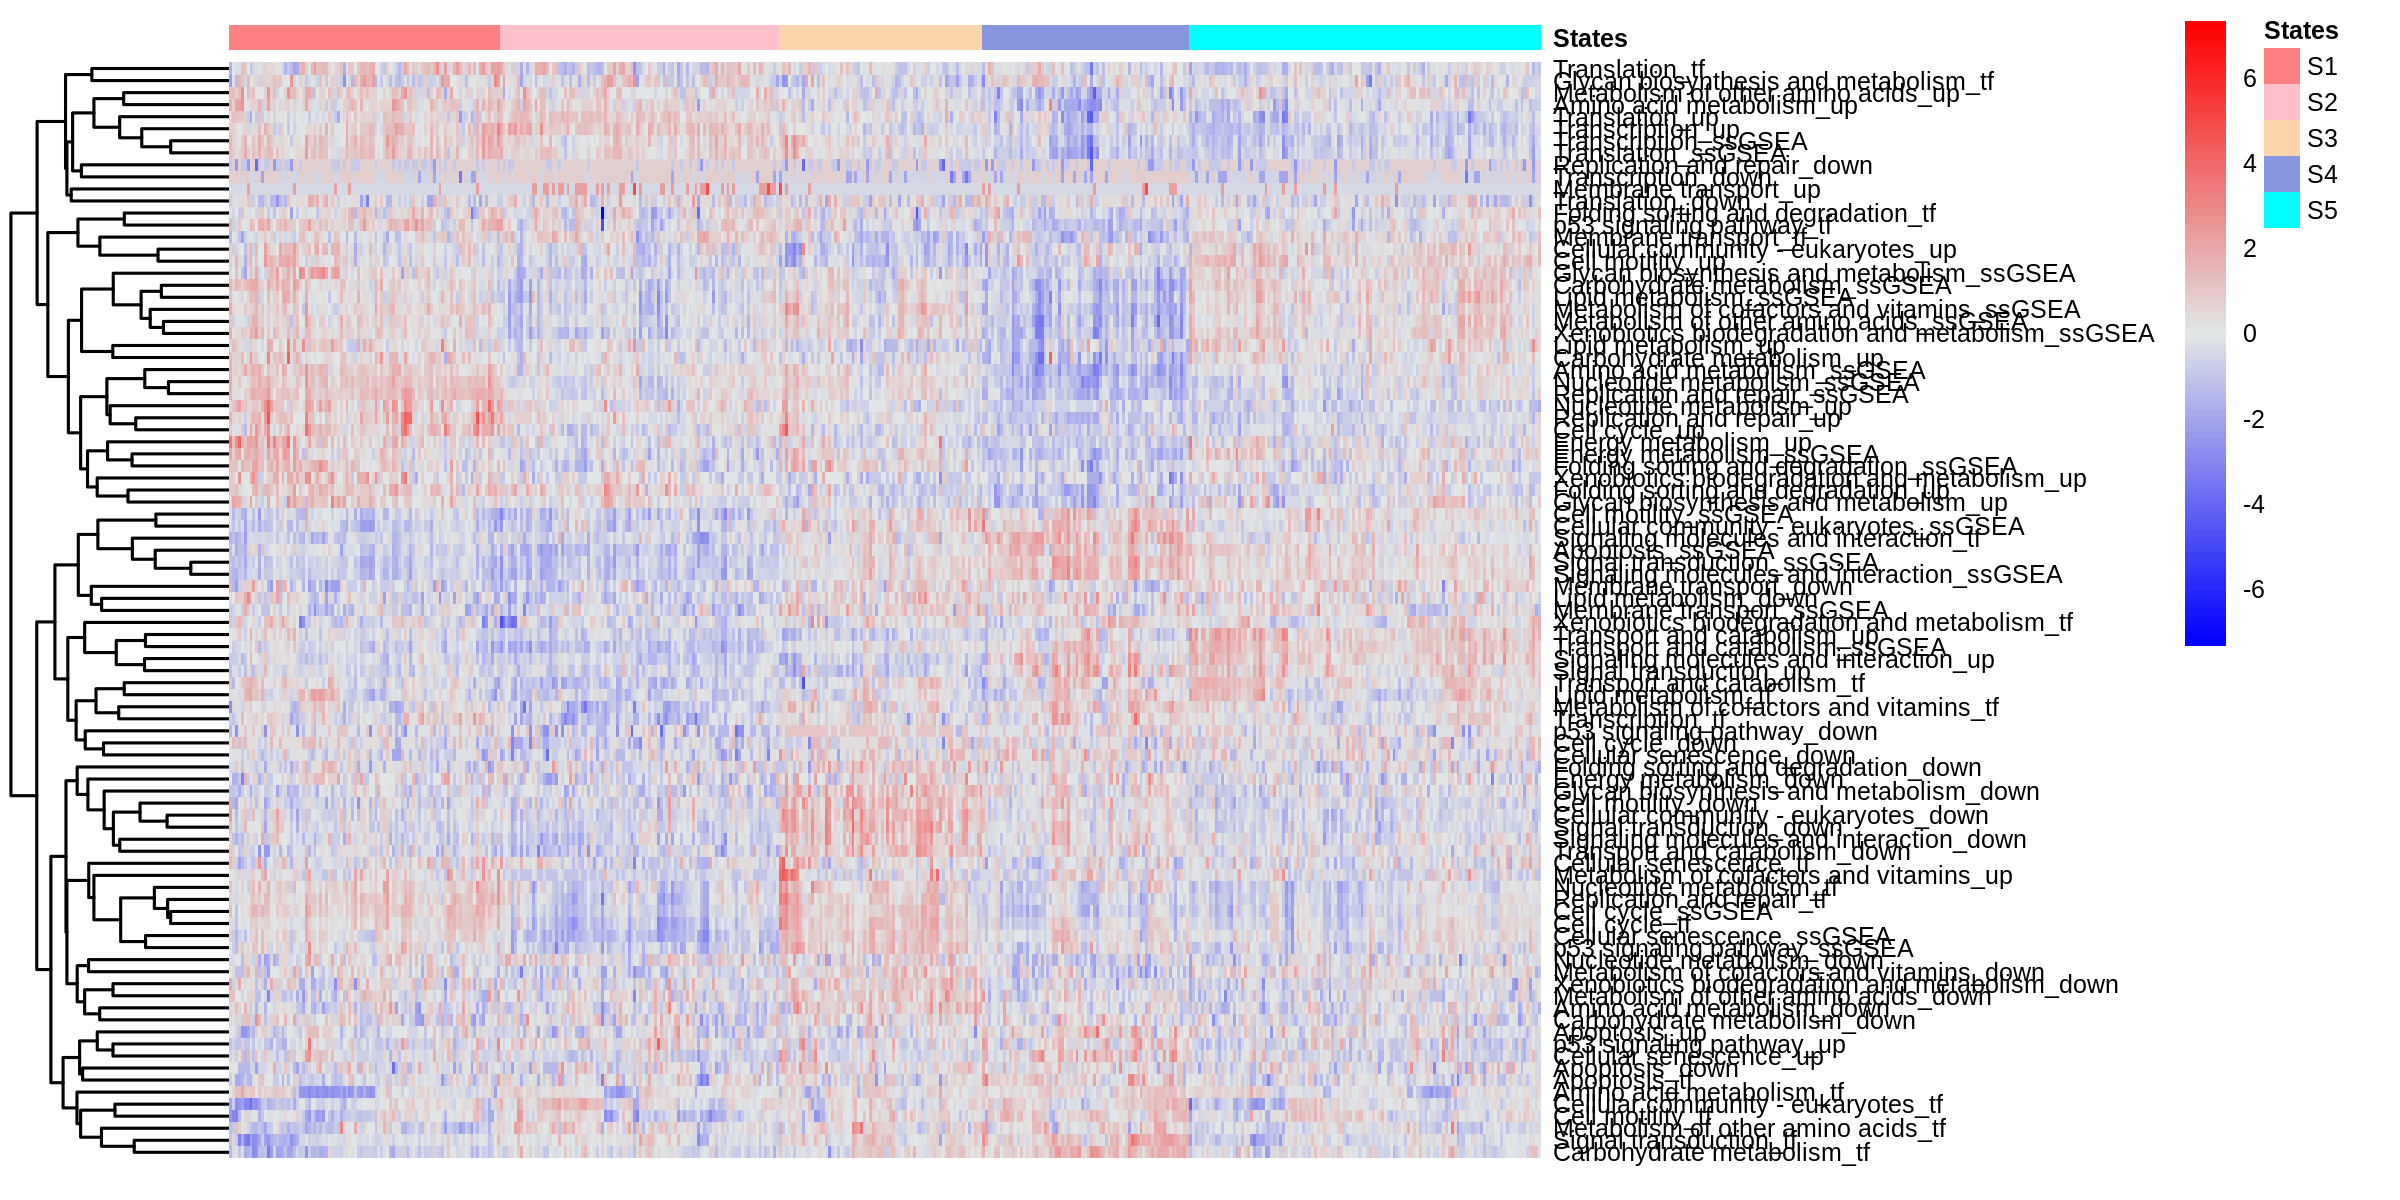

In [20]:
%%R -i Cluster_results,Br,select_modules,cluster_sele,colors,list_labe,out_dir   -w 8 -h 4 --units in -r 300
#User specific orders
library(pheatmap)
plot_heatmap <- function(Cluster_results, Br, select_modules,cl_num_sele){

list_labe_R = c()
Rename_Label = c()
color_list = c()

for (i in seq(1,length(list_labe))){
    list_labe_R = append(list_labe_R, list_labe[[i]][1])
    Rename_Label = append(Rename_Label,paste('S',i,sep = ''))
    color_list = append(color_list, colors[[i]][1])
}

names(Rename_Label) = list_labe_R  
names(color_list) = Rename_Label
anno_colors = list(States = color_list)

    
cl_sam = Cluster_results[[cl_num_sele]]$consensusClass
names(cl_sam) = rownames(Br)
annotation_col_1 = data.frame(cl_sam)
Factors = t(Br[,select_modules])
labe = paste('S',annotation_col_1[,1],sep = '')
names(labe) = rownames(annotation_col_1)

annotation_col_1 = c()
names_1 =c()

  

for(i in unique(list_labe_R) ){ 
  if (length(labe[which(labe == i)]) > 2){ 
      result_hclust = hclust(dist((Br[names(labe[which(labe == i)]),])))
      names_1 = c(names_1, names(labe[which(labe == i)])[result_hclust$order])
      annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))
     }
    else{ 
    names_1 = c(names_1, names(labe[which(labe == i)]))
    annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))}
}
annotation_col_1 = data.frame(annotation_col_1)
rownames(annotation_col_1) = names_1
colnames(annotation_col_1) = c('States')


    
write.csv(annotation_col_1, file = paste(out_dir,"/annotation_col.csv",sep = ''))
color_forpheatmap = c(c(colorRampPalette(c("#0000ff", "#e1e5e5"))(60),c(colorRampPalette(c("#e1e5e5","#ff0000"))(60)) ))
    
pheatmap(t(Br[names_1,select_modules]),
         annotation_col = annotation_col_1,
         annotation_colors = anno_colors[1],
         labels_col = '',
         fontsize = 6,
         cluster_cols = FALSE,scale = 'row', 
         color = color_forpheatmap,
         fontsize_row = 6
        )
return(annotation_col_1)
}

annotation_col_1 = plot_heatmap(Cluster_results, Br, select_modules,cluster_sele)

#print(annotation_col_1)

In [21]:
cluster_sele = 5  #selection of clusters

#list_labe = ["S2","S3","S1","S4","S5"] #Reorder the clusters. 
list_labe = ["S4","S2","S3","S5","S1"] #Reorder the clusters. 

colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation
#The number of clusters and order of clusters here only reflects the example we are providing, for different dataset, the orders should be defined by the users.
#matrix_factor_selected = reference_factor_select_modules.loc[:,list(select_modules)]
annotation_col_1 = pd.read_csv(out_dir+"/annotation_col.csv", index_col= 'Unnamed: 0')
#Features = FM_States.Get_features_one_vs_all_others(matrix_factor_selected, 0.01, 0.8, annotation_col_1,select_modules) ##user define threshold

Features, dic_state = FM_States.Get_features_one_vs_one(matrix_factor_selected, 0.01, 1, 3, annotation_col_1,select_modules)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


S4
up regulated in : 
Cellular senescence,Signaling molecules and interaction,Cellular community - eukaryotes,Apoptosis,Signal transduction
up regulated in TF: 
Carbohydrate metabolism,Signaling molecules and interaction,Signal transduction
down regulated in : 
Energy metabolism,Glycan biosynthesis and metabolism,Metabolism of cofactors and vitamins,Amino acid metabolism,Replication and repair,Lipid metabolism,Translation,Xenobiotics biodegradation and metabolism,Folding sorting and degradation,Nucleotide metabolism,Metabolism of other amino acids,Carbohydrate metabolism
down regulated in TF: 
p53 signaling pathway


S2
up regulated in : 
Translation,Transcription
down regulated in : 
p53 signaling pathway,Cell motility,Cellular senescence,Signaling molecules and interaction,Transport and catabolism,Apoptosis,Signal transduction
down regulated in TF: 
Transport and catabolism,Cell cycle,Transcription,Metabolism of cofactors and vitamins


S3
up regulated in : 
p53 signaling pathway,Cel

In [22]:
select_modules = Features.columns.values  #Features are defined by following steps which shows difference between different states

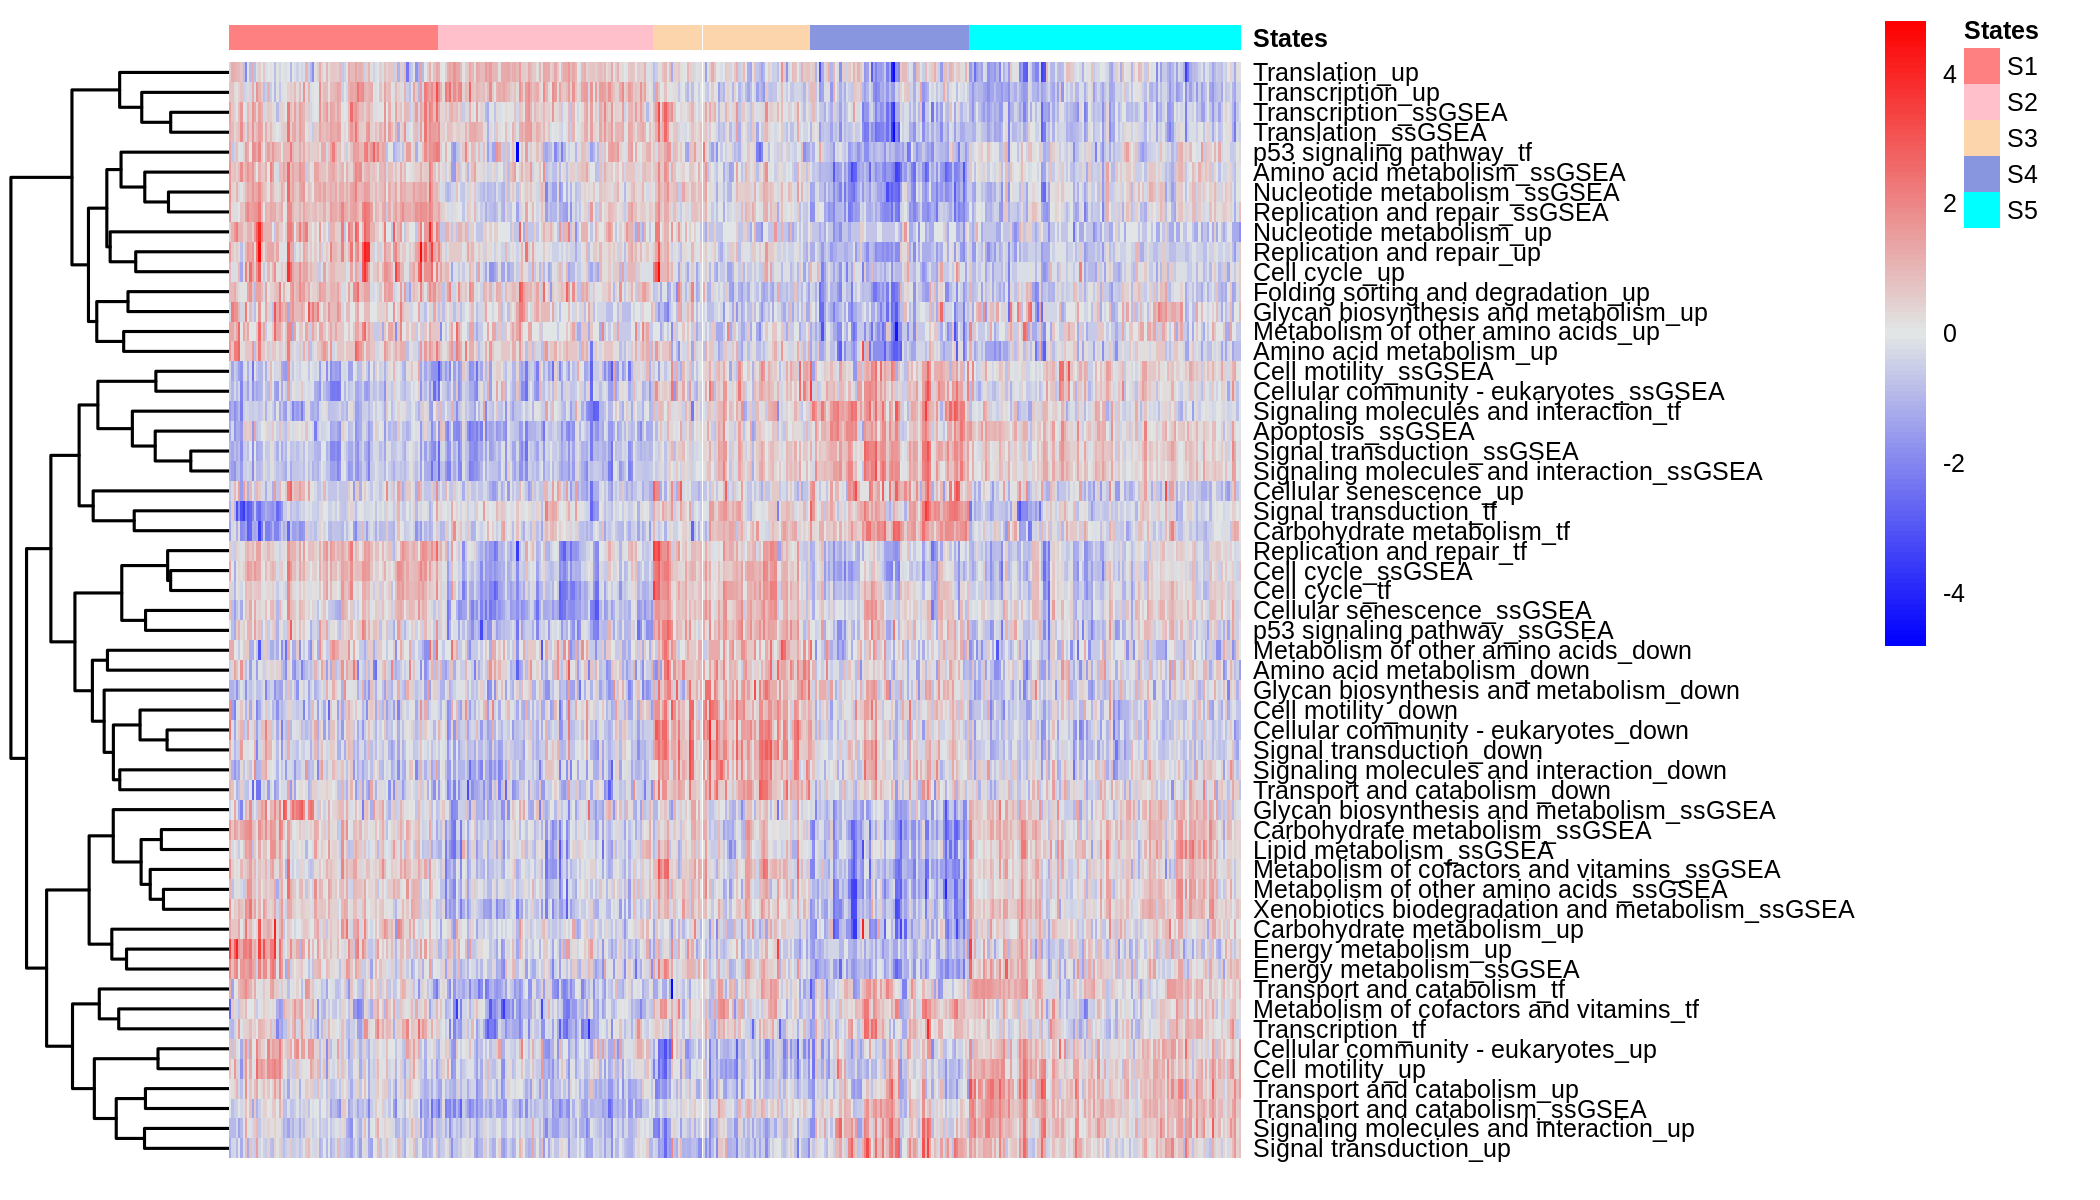

In [77]:
%%R -i Cluster_results,Br,select_modules,cluster_sele,colors,list_labe,out_dir   -w 7 -h 4 --units in -r 300
#User specific orders
library(pheatmap)
plot_heatmap <- function(Cluster_results, Br, select_modules,cl_num_sele){

list_labe_R = c()
Rename_Label = c()
color_list = c()

for (i in seq(1,length(list_labe))){
    list_labe_R = append(list_labe_R, list_labe[[i]][1])
    Rename_Label = append(Rename_Label,paste('S',i,sep = ''))
    color_list = append(color_list, colors[[i]][1])
}

names(Rename_Label) = list_labe_R  
names(color_list) = Rename_Label
anno_colors = list(States = color_list)

    
cl_sam = Cluster_results[[cl_num_sele]]$consensusClass
names(cl_sam) = rownames(Br)
annotation_col_1 = data.frame(cl_sam)
Factors = t(Br[,select_modules])
labe = paste('S',annotation_col_1[,1],sep = '')
names(labe) = rownames(annotation_col_1)

annotation_col_1 = c()
names_1 =c()

  

for(i in unique(list_labe_R) ){ 
  if (length(labe[which(labe == i)]) > 2){ 
      result_hclust = hclust(dist((Br[names(labe[which(labe == i)]),])))
      names_1 = c(names_1, names(labe[which(labe == i)])[result_hclust$order])
      annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))
     }
    else{ 
    names_1 = c(names_1, names(labe[which(labe == i)]))
    annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))}
}
annotation_col_1 = data.frame(annotation_col_1)
rownames(annotation_col_1) = names_1
colnames(annotation_col_1) = c('States')


    
write.csv(annotation_col_1, file = paste(out_dir,"/annotation_col.csv",sep = ''))
color_forpheatmap = c(c(colorRampPalette(c("#0000ff", "#e1e5e5"))(60),c(colorRampPalette(c("#e1e5e5","#ff0000"))(60)) ))
    
pheatmap(t(Br[names_1,select_modules]),
         annotation_col = annotation_col_1,
         annotation_colors = anno_colors[1],
         labels_col = '',
         fontsize = 6,
         cluster_cols = FALSE,scale = 'row', 
         color = color_forpheatmap,
         fontsize_row = 6
        )
return(annotation_col_1)
}

annotation_col_1 = plot_heatmap(Cluster_results, Br, select_modules,cluster_sele)

#print(annotation_col_1)

In [73]:
modules = []
for key in dic_state:
    for key1 in dic_state[key]:
        modules = modules + dic_state[key][key1]
modules = list(set(modules))

result = pd.DataFrame()
#for state in ["S4","S2","S3","S5","S1"]:
for state in ["S1","S2","S3","S4","S5"]:
    cur_state = []
    for module in modules:
        if (module in dic_state[state]['up']) and (module not in dic_state[state]['down']):
            cur_state.append(1)
        elif (module  in dic_state[state]['down']) and ( module not in dic_state[state]['up']):
            cur_state.append(-1)
        elif (module  in dic_state[state]['down']) and (module  in dic_state[state]['up']):
            cur_state.append(0.5)
        elif module not in dic_state[state]:
            cur_state.append(0)
    result[state] = cur_state 

result.index = modules
result = result[~(result == 0).all(1)]

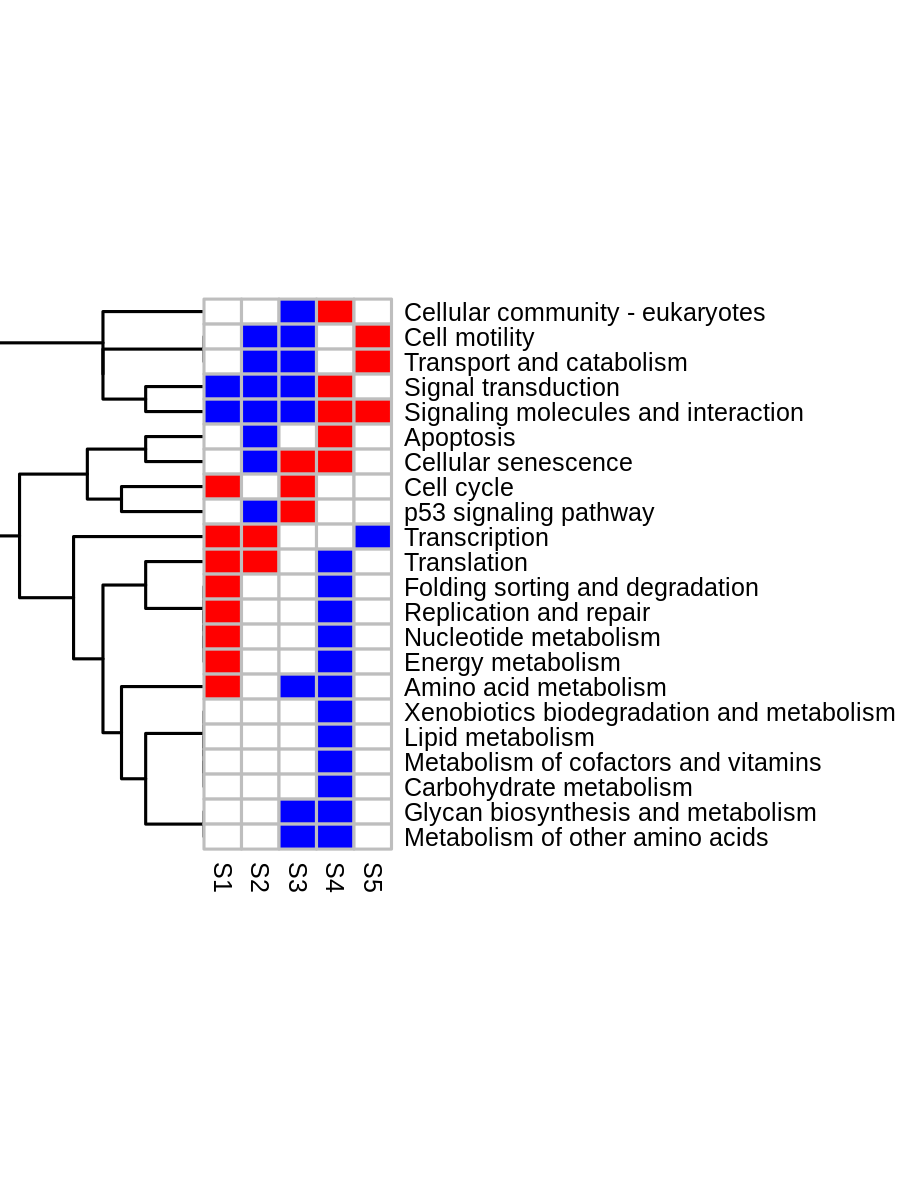

In [75]:
%%R -i result -w 3 -h 4 --units in -r 300

n = 5
order = c()
for (i in seq(1,n)){
    order = c(order, (paste('S',i,sep = '')))
}

Features = result
color_max = max(round(min(Features)*100) * -1, round(max(Features)*100))
#color_forpheatmap2 = c(c(colorRampPalette(c("#0000ff", "white"))(color_max)[(color_max - (round(min(Features)*100) * -1)) : color_max],
#                         c(colorRampPalette(c("white","#ff0000"))(color_max)[1:(round(max(Features)*100))]) ))
color_forpheatmap2 = c("blue","white",'yellow','red')
pheatmap((Features),border_color = "grey",
         border_width = 0.05,
         color = color_forpheatmap2,
         cellwidth = 9,
         cellheight = 6,
         cluster_cols = FALSE,
         fontsize = 6,
         fontsize_row = 6,
         fontsize_col = 6,
         legend = FALSE)

#### 4. Enrichment analysis using gene mutations


In [196]:
mut = pd.read_csv(para['input_dir'] + "Mutation.csv", index_col = "Unnamed: 0")

In [197]:
clinic_data = pd.read_csv(para["input_dir"] +"clinical_data.csv")    

In [198]:
x = clinic_data.loc[clinic_data['LabId'].isin(set(annotation_col_1.index))]
ALL_samples = (set(x.loc[x['analysisExomeSeq'] == 'y']['LabId']))


In [208]:
mut.columns

Index(['chrom', 'pos_start', 'pos_end', 'ref', 'alt', 'labId', 'tumor_only',
       'genotyper', 'total_reads', 'allele_reads', 'normal_total_reads',
       'normal_allele_reads', 't_vaf', 'n_vaf', 'all_consequences',
       'chosen_consequence', 'impact', 'symbol', 'ensembl_gene', 'canonical',
       'refseq', 'biotype', 'exon', 'hgvsc', 'hgvsp', 'cdna_position',
       'cds_position', 'protein_position', 'amino_acids', 'codons',
       'existing_variation', 'variant_class', 'sift', 'polyphen', 'exac_af',
       'short_aa_change', 'validation', 'rna_status'],
      dtype='object')

In [204]:
def action_enrich_gene_mut(Gene, current_clust):
    #print(Gene + ":"+ current_clust)
    mut_int = mut.loc[mut['labId'].isin(ALL_samples)]
    mut_sele = mut_int.loc[mut_int['symbol'] ==(Gene)] #with mutation
    annotation_col_int = annotation_col_1.loc[ALL_samples]
    
    mut_S1 = mut.loc[mut['labId'].isin(list(annotation_col_int.loc[annotation_col_int['States'] == current_clust].index))] # in group
    mut_S1_sele = mut_S1.loc[mut_S1['symbol']==(Gene)] # with mutation in group
    
    ####  creat the 2x2 contingency table    #### 
    ####  ------------------------------------------------ ####
    ####            with_mutation     Without mutation     ####
    #### In_group        A                  B              ####
    #### out_group       C                  D              ####
    #### ------------------------------------------------- ####
    
    A = len(set(mut_S1_sele['labId'])) #number of samples with mutation in group
    B = len(set(annotation_col_int.loc[annotation_col_int['States'] == current_clust].index)) - A  #number of samples in this group without mutation
    C = len(set(mut_sele['labId'])) - A #number of samples with mutation not in this group
    D = len(ALL_samples) - B - C + A #number of samples not in this group and without mutations
    
    f,p = scipy.stats.fisher_exact([[A,B],[C,D]], alternative= 'greater') #Fisher exact test
    result = [Gene, current_clust, p]
    return(result)


In [205]:
mut_state_df = pd.DataFrame()
i = 0

for gene in ["FLT3", "NPM1", "DNMT3A", "IDH2", "RUNX1", "IDH1", "ASXL1","STAG2", "TET2", "TP53", "CEBPA", "WT1", "PTPN11", "NRAS", "KRAS"]:
    for state in ['S1','S2','S3','S4','S5']:
        result = action_enrich_gene_mut(gene, state)
        #print(result)
        if result[2] < 0.05:
            i = i + 1
            mut_state_df[i] = result
mut_state_df = mut_state_df.transpose()
mut_state_df.columns = ['Gene_mutated', 'State', 'p']

neg_log_p = []
for p in (mut_state_df['p'].values):
    neg_log_p.append(-1 * np.log(p))
    
mut_state_df['neg_log_p'] = neg_log_p

[Text(0, 0.5, 'negative log-transformed P-value'), Text(0.5, 0, 'States')]

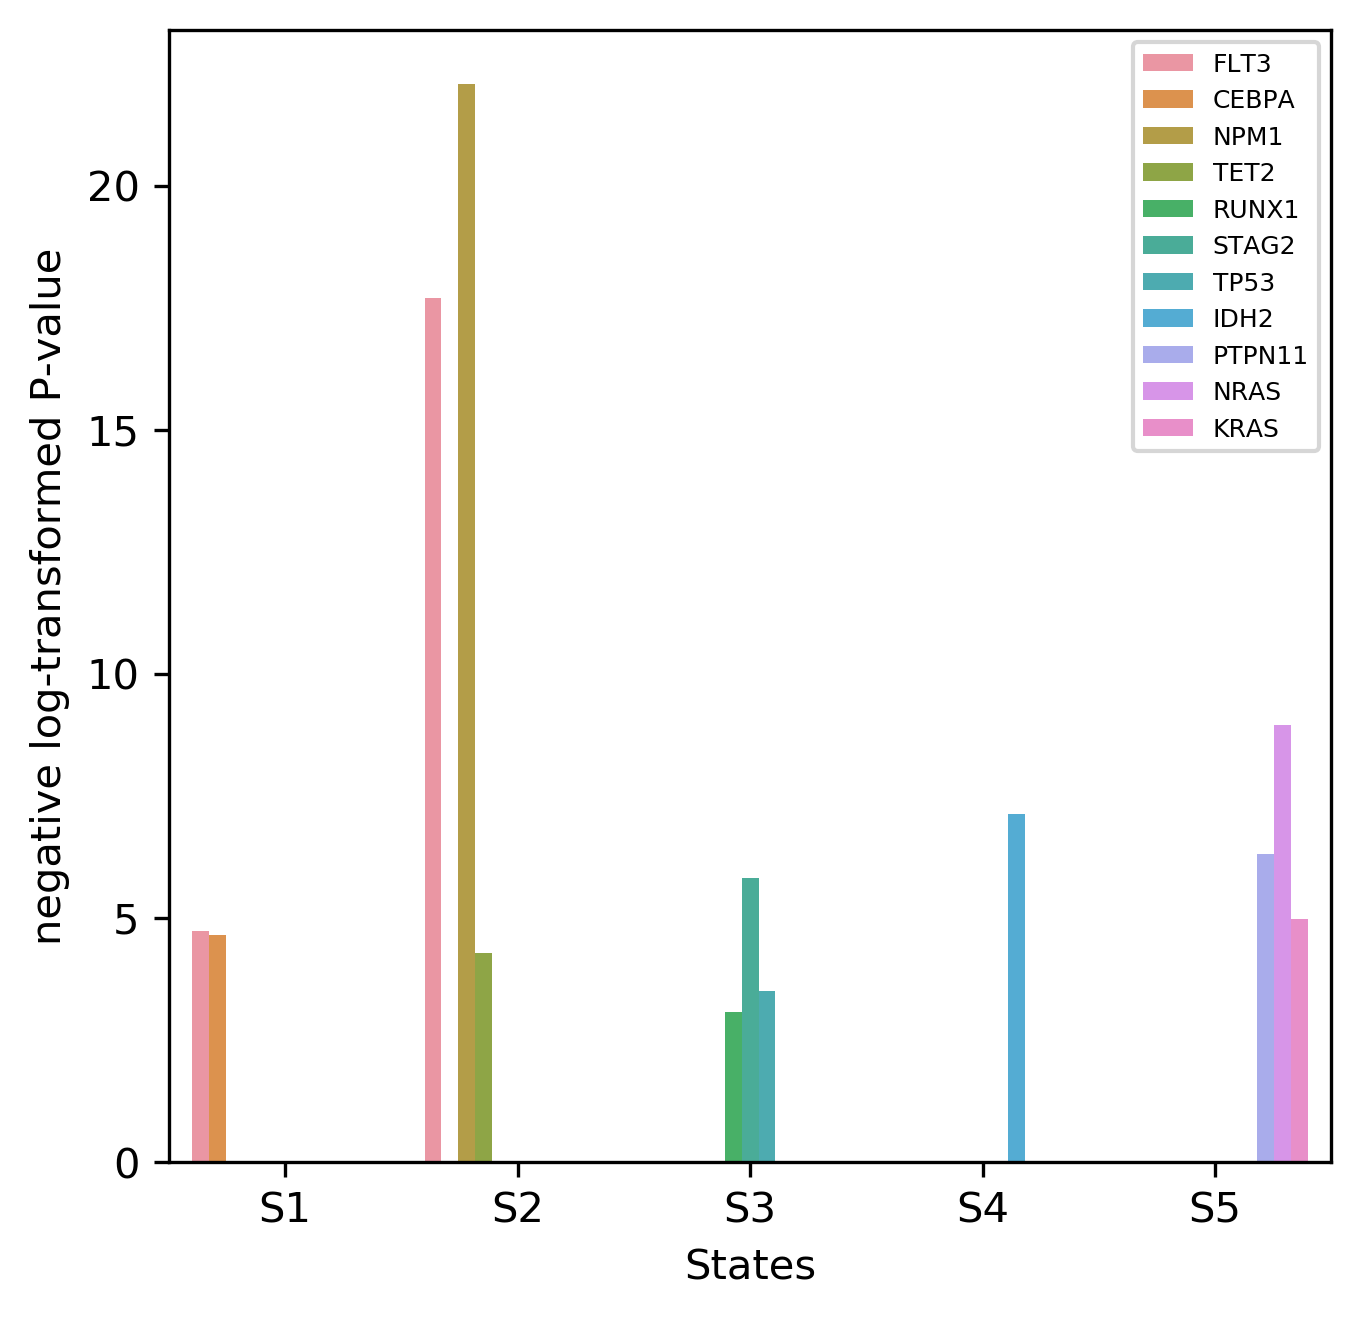

In [206]:

plt.figure(num=None, figsize=(5, 5), dpi=300, facecolor='w', edgecolor='k')

ax = sns.barplot(x="State", y="neg_log_p",  data=mut_state_df.sort_values(by =['State']), 
                 order = ['S1','S2','S3','S4','S5'],  hue = 'Gene_mutated' )
#ax.set_ylabel("-1*log(P)")
h, l = ax.get_legend_handles_labels()
ax.legend(loc = 1, fontsize = 6)

ax.set(xlabel='States', ylabel='negative log-transformed P-value')



#### 5. Comparing the blast percentage across different states

In [56]:
clinic_data = pd.read_csv(para["input_dir"] +"clinical_data.csv")    

In [57]:
clinic_data.index = clinic_data['LabId']

In [58]:
clinic_state = pd.concat([clinic_data, annotation_col_1], sort=True, axis=1)
clinic_state = clinic_state.dropna(subset=['%.Blasts.in.BM'])

In [59]:
def format_column(clinic_state, col):
    new_col = []
    old_col = clinic_state[col]
    for item in old_col:
        
        if item == ">95":
            new_col.append(95)
        elif item  == '>50':
            new_col.append(50)
        elif item == '"rare"' or item == 'rare':
            new_col.append(0)
        elif item == '<5':
            new_col.append(5)
        else:
            new_col.append(float(item))
    clinic_state[col] = new_col
    return(clinic_state)

F_onewayResult(statistic=24.55780016262619, pvalue=1.4662058234216627e-17)


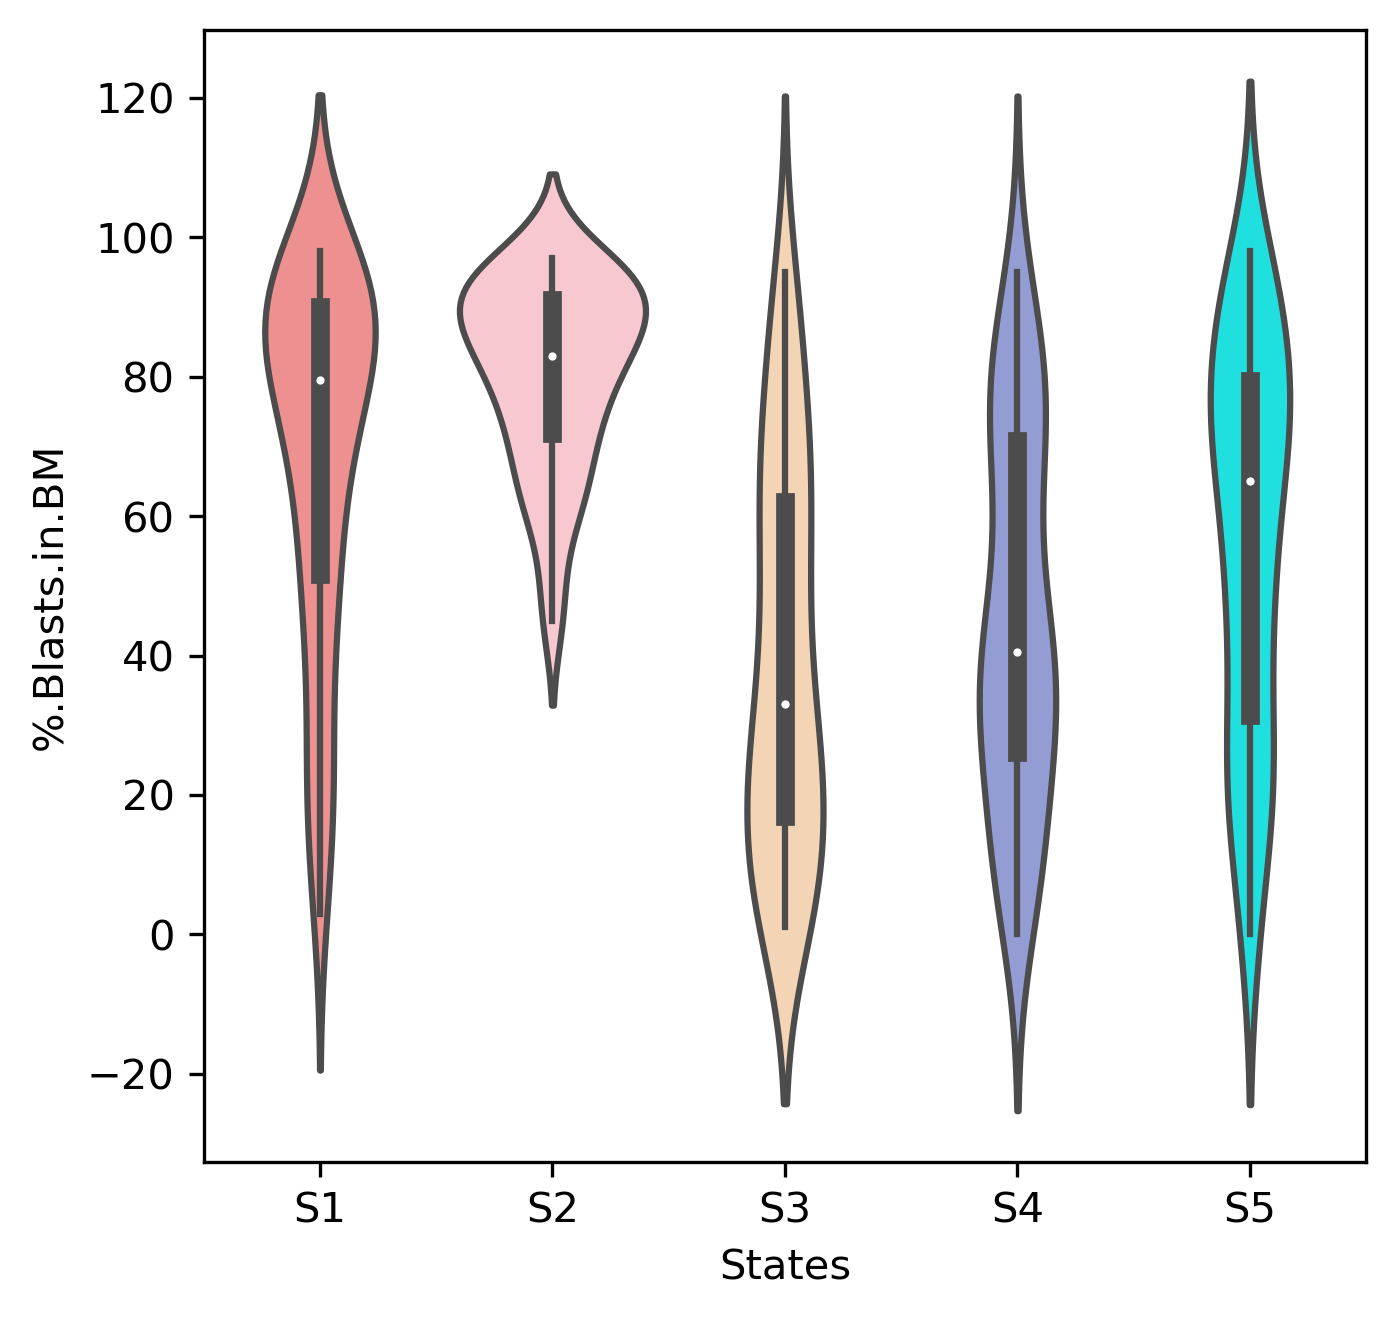

In [213]:
from scipy.stats import f_oneway

X1 = format_clinic_state[format_clinic_state['States'] == "S1"]['%.Blasts.in.BM']
X2 = format_clinic_state[format_clinic_state['States'] == "S2"]['%.Blasts.in.BM']
X3 = format_clinic_state[format_clinic_state['States'] == "S3"]['%.Blasts.in.BM']
X4 = format_clinic_state[format_clinic_state['States'] == "S4"]['%.Blasts.in.BM']
X5 = format_clinic_state[format_clinic_state['States'] == "S5"]['%.Blasts.in.BM']
p = f_oneway(X1, X2, X3, X4, X5)
print(p)

plt.figure(num=None, figsize=(5, 5), dpi=300, facecolor='w', edgecolor='k')
my_pal = {"S1": "#ff8080", "S2": "pink", "S3": "#fdd5ac", "S4":"#8895df", "S5":'cyan'}

format_clinic_state = format_column(clinic_state,'%.Blasts.in.BM')
ax = sns.violinplot(x="States", y="%.Blasts.in.BM", data=format_clinic_state,  order = ['S1','S2','S3','S4','S5'], palette = my_pal)

#### Drug response analysis

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import Drug_response
import Query

import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')
ROOT_DIR = os.path.abspath("../")

In [83]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example_beatAML/",
    'input_dir': ROOT_DIR+"/Sample_input/Example_beatAML/",
    'output_fmf_file':ROOT_DIR+"/Sample_output/Example_beatAML/" +"matrix_factor_beatAML.csv",
    'Label_UP': True,
    'Label_DOWN':True,
    'Label_ssGSEA': True,
    'Label_TF':True,
    'isAbsoluteValues':True,
    'sele_modules': ['Translation',
        'Nucleotide metabolism',
        'Signal transduction',
        'Amino acid metabolism',
        'Folding sorting and degradation',
         'Replication and repair',
         'Carbohydrate metabolism',
         'Membrane transport',
         'Cellular community - eukaryotes',
         'Lipid metabolism',
         'Metabolism of other amino acids',
         'Transcription',
         'Xenobiotics biodegradation and metabolism',
         'Signaling molecules and interaction',
         'Energy metabolism',
         'Transport and catabolism',
         'Glycan biosynthesis and metabolism',
         'Metabolism of cofactors and vitamins',
         'Cell motility',
         'Cell cycle', 
         'Apoptosis', 
         'Cellular senescence', 
         'p53 signaling pathway']
}

In [84]:
## Read the FM-matrix
matrix_factor = pd.read_csv(para['output_dir'] +"/matrix_factor_beatAML.csv", index_col= "Unnamed: 0")
## Read the IC50, AUC and drug annotation tables. Data from GDSC project. 
Drug_IC50_AUC= pd.read_csv(para['input_dir'] +"Drug_Response.csv", index_col= "Unnamed: 0") #This includes all drugs and all cell lines
#Drug_AUC = pd.read_csv(para['input_dir'] +"Drug_AUC_matrix.csv", index_col= "Unnamed: 0")
#DrugInformation = pd.read_csv(para['input_dir'] + '/Drug_annotation.csv', index_col= "Unnamed: 0")

In [85]:
All_drugs = list(set(Drug_IC50_AUC['inhibitor']))
all_samples = list(matrix_factor.index)
all_factors = list(matrix_factor.columns)

In [87]:
df_AUC =  pd.DataFrame()
for drug in All_drugs:
    df_temp = Drug_IC50_AUC.loc[Drug_IC50_AUC['inhibitor'] == drug]
    df_temp.index = df_temp['lab_id']
    df_temp[drug] = df_temp['auc']
    df_AUC = pd.concat([df_AUC,df_temp[drug]], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [89]:
Matrix_factor_drug = pd.concat([matrix_factor, df_AUC], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [92]:
from scipy.stats import spearmanr, pearsonr
df_cor = pd.DataFrame()
i = 0
for drug in All_drugs:
    for factor in all_factors:
        df_temp = Matrix_factor_drug.loc[:,[drug, factor]]
        df_temp = df_temp.dropna()
        #print(df_temp)
        result = (spearmanr(df_temp[factor], df_temp[drug]))
        cor = result[0]
        p = result[1]
        result = [drug, factor, cor, p]
        df_cor[i] =result
        i = i + 1

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [93]:
df_cor = df_cor.transpose()

In [94]:
df_cor.columns = ['Drug','Factor','Cor','P']
neg_log_p = []

for p in (df_cor['P'].values):
    neg_log_p.append(-1 * np.log(p))
    
df_cor['neg_log_p'] = neg_log_p



In [95]:
df_cor_sig = df_cor.loc[df_cor['P'] < 0.05]

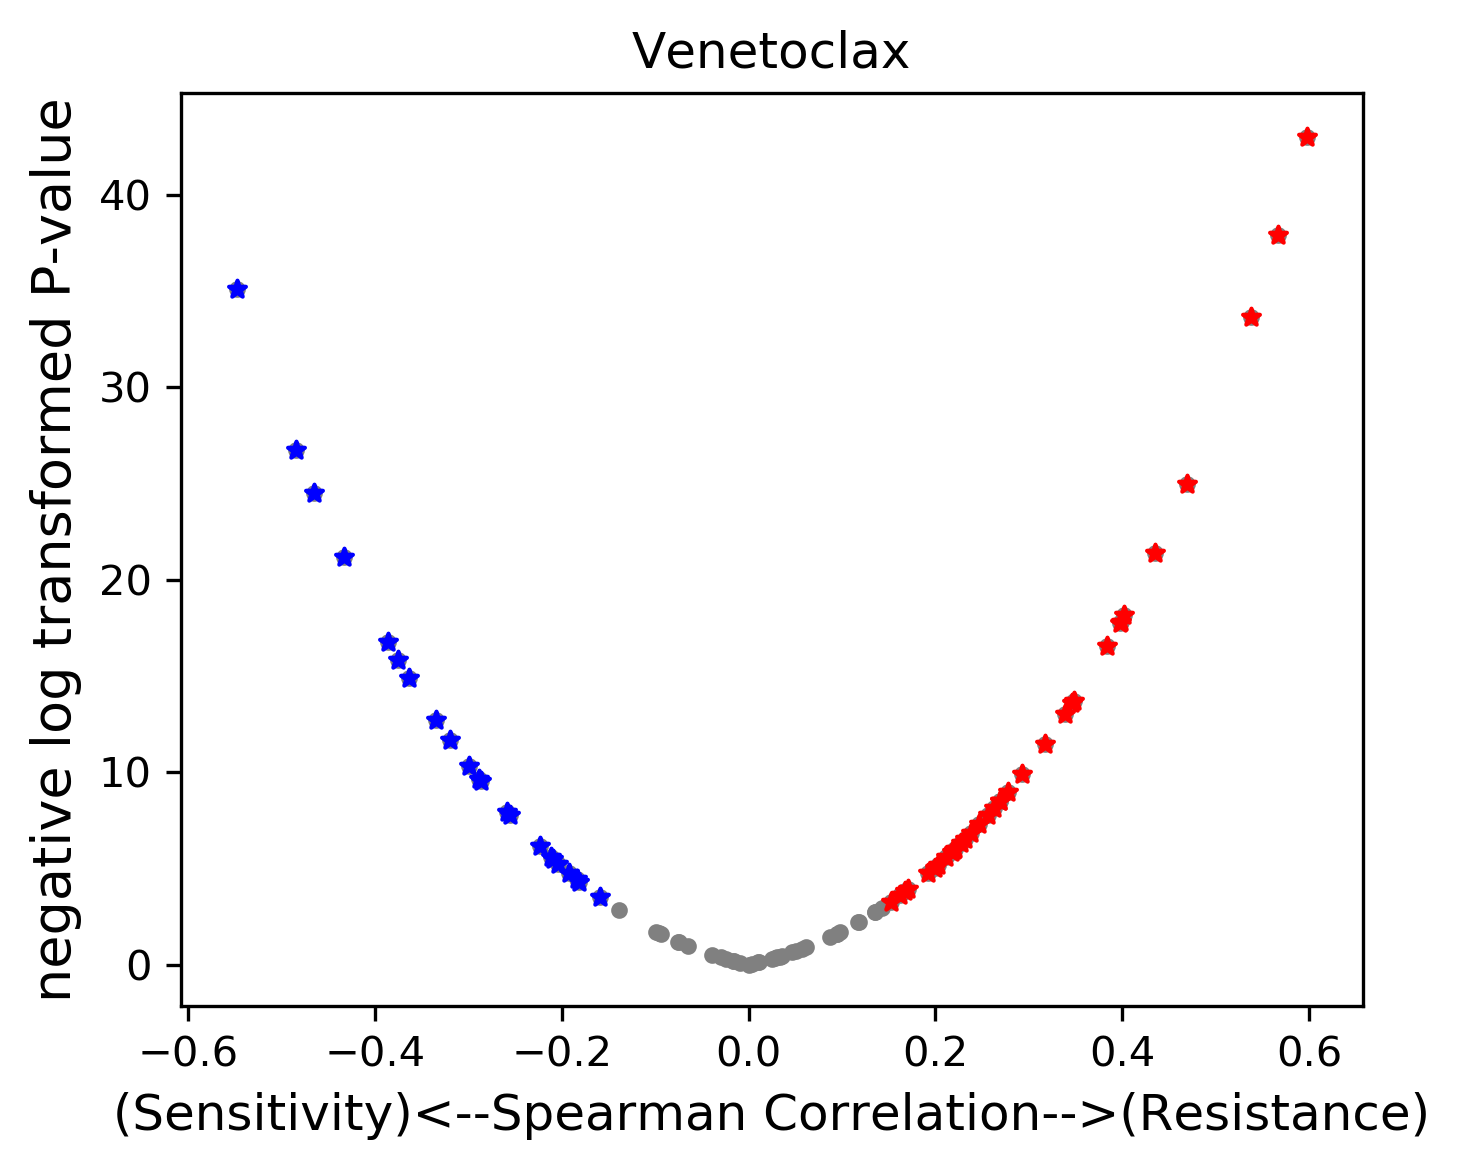

In [119]:
#Trametinib (GSK1120212)
#JQ1
#Venetoclax
Drug = "Venetoclax"

result_pd = df_cor.loc[df_cor['Drug']==Drug]
result_pd_sig =  result_pd.loc[result_pd['P'] < 0.05]
result_sig_neg = result_pd_sig.loc[result_pd_sig['Cor'] < 0]
result_sig_pos = result_pd_sig.loc[result_pd_sig['Cor'] > 0]

plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')

plt.xlabel("(Sensitivity)<--Spearman Correlation-->(Resistance)", fontsize =  12)
plt.ylabel("negative log transformed P-value", fontsize =  13)

plt.scatter(result_pd['Cor'],result_pd['neg_log_p'],c='grey', marker = ".")
plt.scatter(result_sig_neg['Cor'],result_sig_neg['neg_log_p'],c='b',marker = "*", s = 18)
plt.scatter(result_sig_pos['Cor'],result_sig_pos['neg_log_p'],c='r',marker = "*", s = 18)  
plt.title(Drug)
plt.tight_layout()


In [103]:
result_sig_pos.sort_values(by = ['Cor'], ascending = False)

,Drug,Factor,Cor,P,neg_log_p
3102,Venetoclax,Transport and catabolism_ssGSEA,0.597921,2.05097e-19,43.030803
3099,Venetoclax,Signaling molecules and interaction_ssGSEA,0.566674,3.4338e-17,37.910278
3098,Venetoclax,Signal transduction_ssGSEA,0.538102,2.36257e-15,33.679028
3083,Venetoclax,Apoptosis_ssGSEA,0.469498,1.38086e-11,25.005729
3086,Venetoclax,Cell motility_ssGSEA,0.435574,5.1835e-10,21.380370
3088,Venetoclax,Cellular senescence_ssGSEA,0.402162,1.27139e-08,18.180568
3106,Venetoclax,Transport and catabolism_tf,0.398309,1.79864e-08,17.833650
3036,Venetoclax,Signaling molecules and interaction_up,0.397391,1.95238e-08,17.751633
3037,Venetoclax,Transport and catabolism_up,0.383602,6.49688e-08,16.549358
3105,Venetoclax,Signaling molecules and interaction_tf,0.348435,1.09594e-06,13.723896


In [102]:
result_sig_neg.sort_values(by = ['Cor'])

,Drug,Factor,Cor,P,neg_log_p
3055,Venetoclax,Transcription_up,-0.548255,5.50041e-16,35.136538
3101,Venetoclax,Translation_ssGSEA,-0.484544,2.42372e-12,26.745719
3038,Venetoclax,Folding sorting and degradation_up,-0.465169,2.24307e-11,24.520589
3100,Venetoclax,Transcription_ssGSEA,-0.433709,6.25532e-10,21.192418
3054,Venetoclax,Translation_up,-0.38602,5.28295e-08,16.756196
3044,Venetoclax,Replication and repair_up,-0.375063,1.33107e-07,15.832115
3040,Venetoclax,Nucleotide metabolism_up,-0.363434,3.42174e-07,14.887945
3048,Venetoclax,Amino acid metabolism_up,-0.334492,3.0679e-06,12.694519
3110,Venetoclax,p53 signaling pathway_tf,-0.319674,8.68144e-06,11.654323
3049,Venetoclax,Cell cycle_up,-0.299803,3.22127e-05,10.343150


In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [131]:
def convert_toInt(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(int(i)) 
    return(res)

def convert(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(str(i)) 
    return(res)

In [132]:
BeatAML_expression = expr_m

In [133]:
df_ic50 =  pd.DataFrame()
for drug in All_drugs:
    df_temp = Drug_IC50_AUC.loc[Drug_IC50_AUC['inhibitor'] == drug]
    df_temp.index = df_temp['lab_id']
    df_temp[drug] = df_temp['ic50']
    df_ic50 = pd.concat([df_ic50,df_temp[drug]], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [134]:
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import Drug_response
import Query


In [135]:
effect_drugs = ["Venetoclax"]

In [238]:
df_acc_E = pd.DataFrame()
df_acc_F = pd.DataFrame()

accuracy_F = []
accuracy_E = []
   
    
for drug in ['Venetoclax']:
    y = df_ic50[drug] 
    y = y.loc[y.isna()==False]
    samples = y.index.values.tolist()
    samples = list(set(samples).intersection(set(matrix_factor.index)))
    data = matrix_factor.loc[samples,:]
    y = y[samples]
    #data
    # fac = cor_matrix_sig.loc[drug]
    fac_used = matrix_factor.columns.tolist()
    X = data[fac_used]
    X = X[list((set(X.columns)) - set(['States']))]
 
    y = y
    y[y > 0.1] = 1
    y[y < 0.1] = 0
    
    X_E = BeatAML_expression.loc[samples,:]
    #print(drug)
    for i in range(0,100):
        X_train_F, X_test_F, y_train, y_test = train_test_split(X, y, test_size=0.2)     
        X_train_E = X_E.loc[(list(X_train_F.index.to_list()))]
        X_test_E = X_E.loc[(list(X_test_F.index.to_list()))]


        clf_F = RandomForestClassifier(n_estimators = 100, max_depth=None,
                                                  random_state=None)

        clf_F.fit(X_train_F, y_train)
        scores = clf_F.score(X_test_F, y_test)


        clf_E = RandomForestClassifier(n_estimators = 100, max_depth=None,
                                                  random_state=None)
        clf_E.fit(X_train_E, y_train)
        scores_E = clf_E.score(X_test_E, y_test)
        
        accuracy_F.append(scores)
        accuracy_E.append(scores_E)

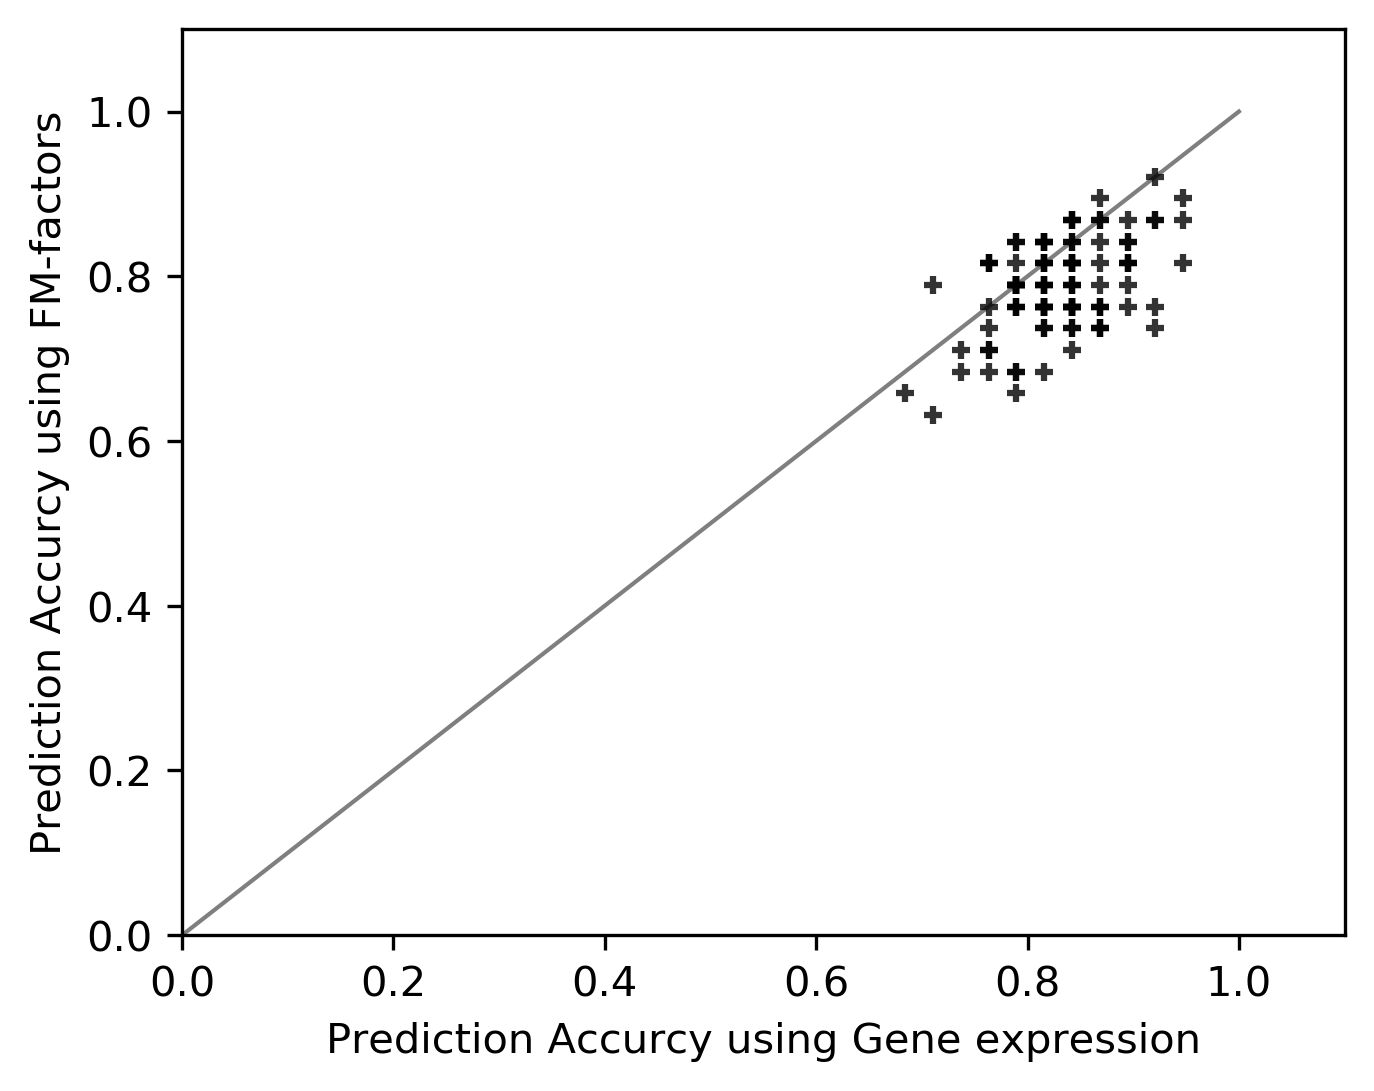

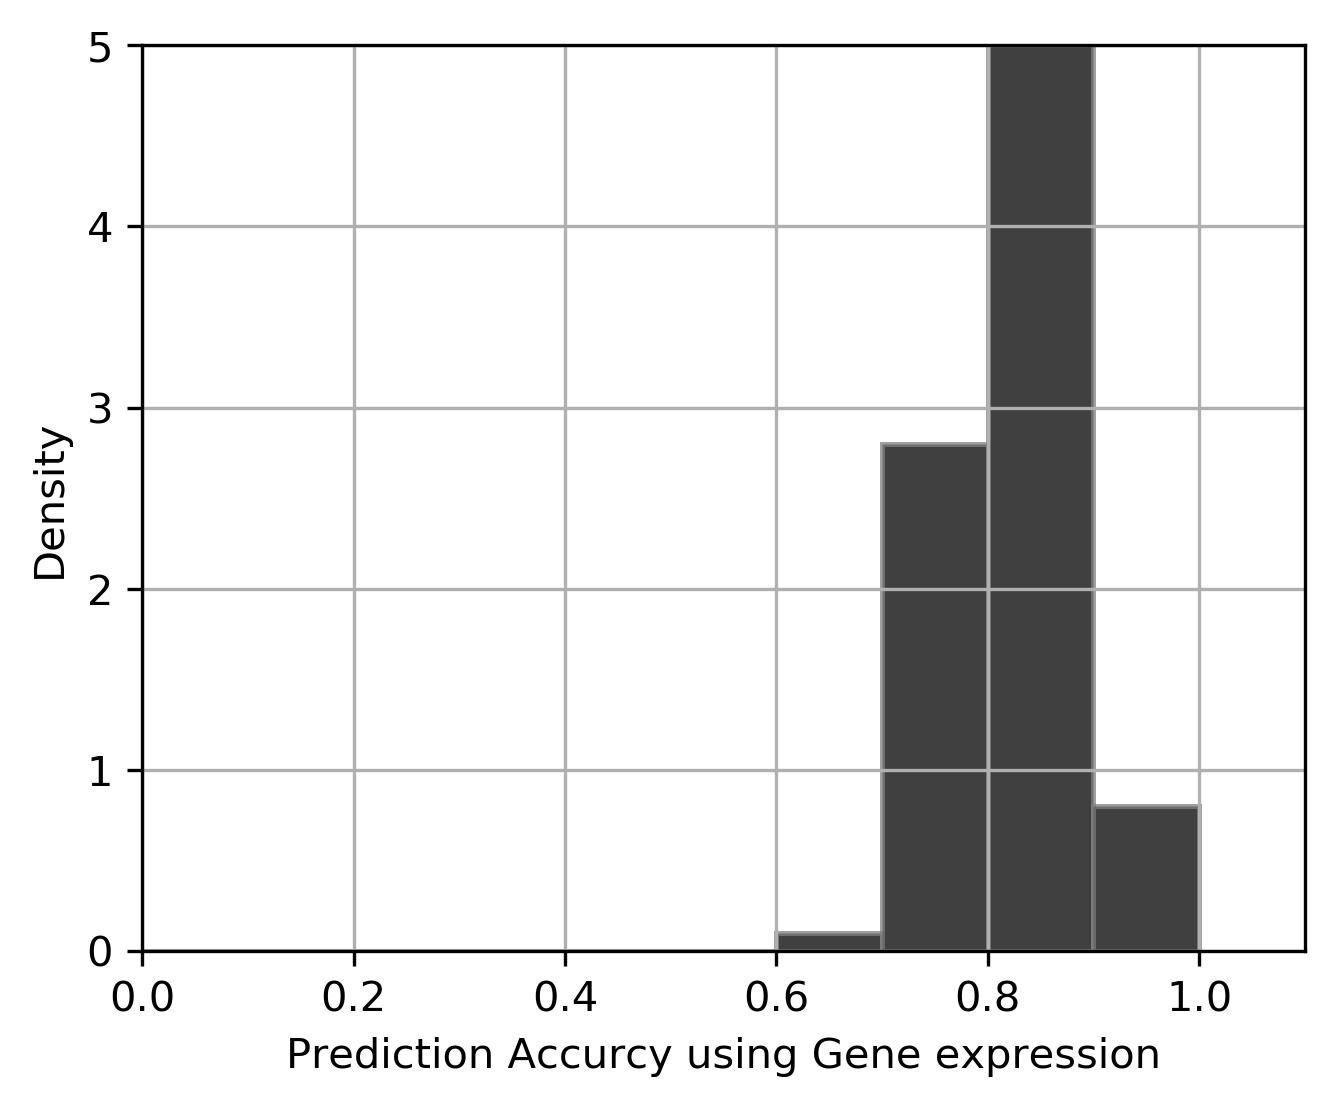

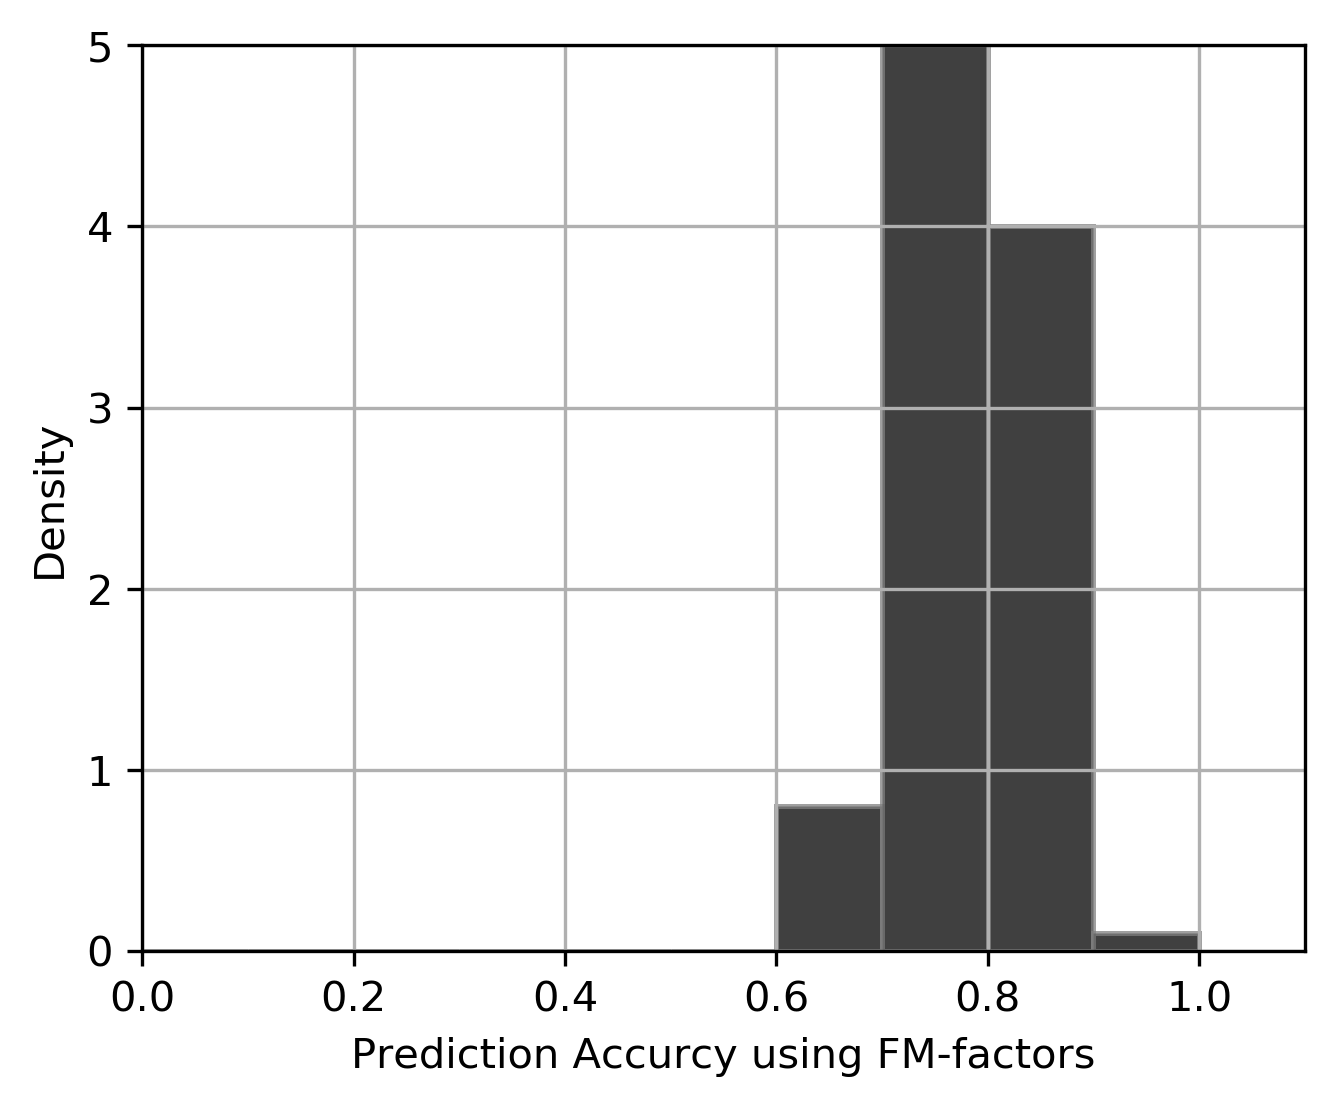

In [239]:
result = pd.DataFrame({'Drug':["Venetoclax"] * 100, 'Acc_F':accuracy_F, 'Acc_E':accuracy_E })
#result.to_csv(para['output_dir'] + "accuracy.csv")

import matplotlib.pyplot as plt
import numpy as np
plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_E']
y = result['Acc_F']

plt.scatter(x, y, s=20, c="k", alpha=0.8, marker='+')
plt.xlabel("Prediction Accurcy using Gene expression")
plt.ylabel("Prediction Accurcy using FM-factors")
plt.xlim((0, 1.1))
plt.ylim((0, 1.1))

xrange = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
yrange = xrange
plt.plot(xrange, yrange, 'k-', alpha=0.5, linewidth=1)
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_E']

# the histogram of the data
n, bins, patches = plt.hist(x, np.arange(0, 1.05, 0.1), density=True, facecolor='k', alpha=0.75, stacked = True, edgecolor='grey', linewidth=1.2)


plt.xlabel('Prediction Accurcy using Gene expression')
plt.ylabel('Density')
#plt.title('Histogram of ACC_E')
plt.xlim(0, 1.1)
plt.ylim(0, 5)
plt.grid(True)
plt.show()

plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_F']

# the histogram of the data
n, bins, patches = plt.hist(x, np.arange(0, 1.05, 0.1), density=True, facecolor='k', alpha=0.75, stacked = True, edgecolor='grey', linewidth=1.2)


plt.xlabel('Prediction Accurcy using FM-factors')
plt.ylabel('Density')
#plt.title('Histogram of ACC_F')
plt.xlim(0, 1.1)
plt.ylim(0, 5)
plt.grid(True)
plt.show()

In [240]:
np.median(result['Acc_F'])

0.7894736842105263

In [241]:
np.median(result['Acc_E'])

0.8289473684210527